In [1]:
import json

In [2]:


experiments_path = "../"

def fc_to_string(k,cfg):
    res = f"k_{k}bits_"
    for layer in cfg:
        res += str(layer["bits"]) + "."
    
    res +=  "logsize_"
    for layer in cfg:
        res = res + str(layer["logsize"]) + "."
    
    return res


def bits_str(cfg):
    res = "b."
    for layer in cfg:
        res += str(layer["bits"]) + "."
    
    return res

def logsize_str(cfg):
    res = "sz."
    for layer in cfg:
        res = res + str(layer["logsize"]) + "."
    
    return res
  
def load_configs(name):
    with open(f'{experiments_path}config_{name}', 'r') as myfile:
        data=myfile.read()
        obj = json.loads(data)
        return obj["config"]  

def load_exp(fn):
    try:
        with open(fn, 'r') as myfile:
            data=myfile.read()
            # print(data)
            obj = json.loads(data)
            return obj
    except Exception as err:
        print(err)
        return None

    
polygon_sets = [("Us Zip Codes", "tl_2017_us_zcta510"), ("Global LSB", "Global_LSIB_Polygons_Detailed")]
datasets =[("Twitter 1 mio","twitter_1mio_coords.h5"), 
           ("Twitter 10 mio","twitter_10mio_coords.h5"),
           ("Twitter 100 mio","twitter_100mio_coords.h5"),
           ("Twitter 100 mio","twitter_100mio_coords.h5"),
           ("Asia 100 mio","asia_100mio_coords.h5"),
           ("Asia 200 mio","asia_200mio_coords.h5"),
           ("Asia 500 mio","asia_500mio_coords.h5"),
           ("Asia 1 bil","asia_1bil_coords.h5"),
          
          
          ]

In [3]:
k = 8;
x = 0;
width = 16 * 8192
height = 16 * 8192;
exp_name = "test_polygons";

cfgs = load_configs(exp_name)
print(len(cfgs))


432


7 12 308
{'b.1.8.': 0, 'b.1.16.': 1, 'b.1.32.': 2, 'b.1.64.': 3, 'b.8.16.': 4, 'b.8.32.': 5, 'b.8.64.': 6}
{'sz.16.20.': 0, 'sz.16.24.': 1, 'sz.16.28.': 2, 'sz.20.16.': 3, 'sz.20.24.': 4, 'sz.20.28.': 5, 'sz.24.16.': 6, 'sz.24.20.': 7, 'sz.24.28.': 8, 'sz.28.16.': 9, 'sz.28.20.': 10, 'sz.28.24.': 11}
{'k_8bits_1.logsize_16.': 90, 'k_8bits_1.8.logsize_16.20.': 19, 'k_8bits_1.8.16.logsize_16.20.24.': 2, 'k_8bits_1.8.32.logsize_16.20.24.': 3, 'k_8bits_1.8.64.logsize_16.20.24.': 4, 'k_8bits_1.16.logsize_16.20.': 23, 'k_8bits_1.16.32.logsize_16.20.24.': 6, 'k_8bits_1.16.64.logsize_16.20.24.': 7, 'k_8bits_1.32.logsize_16.20.': 26, 'k_8bits_1.32.64.logsize_16.20.24.': 9, 'k_8bits_1.64.logsize_16.20.': 28, 'k_8bits_8.logsize_16.': 101, 'k_8bits_8.16.logsize_16.20.': 30, 'k_8bits_8.16.32.logsize_16.20.24.': 13, 'k_8bits_8.16.64.logsize_16.20.24.': 14, 'k_8bits_8.32.logsize_16.20.': 33, 'k_8bits_8.32.64.logsize_16.20.24.': 16, 'k_8bits_8.64.logsize_16.20.': 35, 'k_8bits_1.8.16.logsize_16.20.28.'

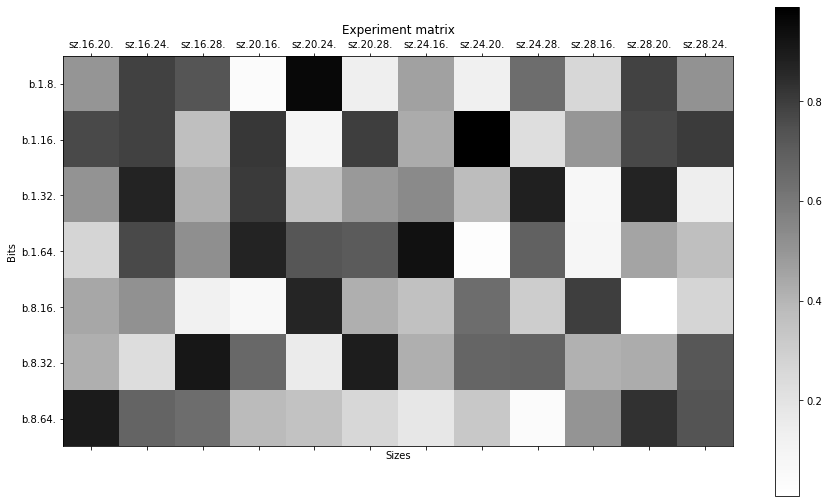

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import matplotlib.backends.backend_pdf as pdf
import tqdm

def save_figs(fn):
    print(f"-->  Saving all figures... {fn}")
    out_pdf = pdf.PdfPages(fn)
    for fig in tqdm.tqdm(range(1, plt.gcf().number+1)):
        out_pdf.savefig( fig )
    out_pdf.close()
    plt.close("all")


def plot_matrix(cm, title='Experiment matrix', cmap='Greys', xlabels=None, ylabels=None, cblabel=None):
    fig = plt.figure(figsize=(len(xlabels)*1.25, 2+ len(ylabels)))
    ax = fig.add_subplot(111)
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    cax = ax.matshow(cm,cmap=cmap)
    plt.title(title)
    ax.set_xticks(range(len(xlabels)))
    ax.set_yticks(range(len(ylabels)))
    cbar = fig.colorbar(cax)

    if cblabel:
        cbar.set_label(cblabel)
    if xlabels:
        ax.set_xticklabels(list(xlabels))
    if ylabels:
        ax.set_yticklabels(list(ylabels))
    plt.xlabel('Sizes')
    plt.ylabel('Bits')
    #plt.show()


def make_maps(size, cfgs):
    bits_map = {}
    logsize_map = {}
    numba = {}
    count_bits =0
    count_sizes = 0
    counter = 0
    for c in cfgs :

        if len(c) ==size:
            if(not bits_str(c) in bits_map):
                bits_map[bits_str(c)] = count_bits
                count_bits+=1
            if(not logsize_str(c) in logsize_map):
                logsize_map[logsize_str(c)] = count_sizes
                count_sizes+=1
        numba[fc_to_string(k,c)] = counter
        counter += 1
                
    return bits_map, logsize_map, numba

bits_map, logsize_map, numba = make_maps(2,cfgs)

print(len(bits_map), len(logsize_map), len(numba))
print(bits_map)
print(logsize_map)
print(numba)
a = np.random.rand(len(bits_map), len(logsize_map))
plot_matrix(a, ylabels=bits_map.keys(), xlabels=logsize_map.keys())


In [5]:
datasets =[("Twitter 1 mio","twitter_1mio_coords.h5"), 
           ("Twitter 10 mio","twitter_10mio_coords.h5"),
          ]


def make_matrices(size, cfgs):
    bits_map, logsize_map, numba = make_maps(size,cfgs)
    matrices= {}
    matrix_indices = ["err_mean_pc"]
    for shapen,shapef in polygon_sets:
        matrices[shapef] = {}
        for dn, ds in datasets :
            matrices[shapef][ds] = {}
            for mi in matrix_indices:
                matrices[shapef][ds][mi] = np.zeros((len(bits_map),(len(logsize_map))))-1



    x=0
    for c in cfgs :
        # print(fc_to_string(k,c))
        y = 0;
        for shpn, shapef in polygon_sets:
            for  dn, ds in datasets :
                idd = fc_to_string(k,c)
                fn = experiments_path + exp_name + "/" + exp_name + f'.w{width}h{height}.{x:04d}.{y}-' + idd \
                + ds + "." + shapef + ".json"
                # print(fn)
                data = load_exp(fn)
                bits = bits_str(c)
                sz = logsize_str(c)
                if data and bits in bits_map and  sz in logsize_map:
                    for mi in matrix_indices:
                        matrices[shapef][ds][mi][ bits_map[bits],logsize_map[sz]] = data[mi]
            y+=1
        x+=1

    for shpn, shapef in polygon_sets:
        for  dn, ds in datasets :
            for mi in matrix_indices:   
                plot_matrix( matrices[shapef][ds][mi] ,title=f'{dn}-{shpn}',ylabels=bits_map.keys(), xlabels=logsize_map.keys(), cblabel=f"% Error")             

make_matrices(1, cfgs)   
make_matrices(2, cfgs)              
make_matrices(3, cfgs)              


save_figs("polygons_test_matrices.pdf")

-->  Saving all figures... polygons_test_matrices.pdf


100%|██████████| 12/12 [00:00<00:00, 16.48it/s]


In [6]:
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib.backends.backend_pdf as pdf
from mpl_toolkits.mplot3d import axes3d
figsize= (8,8)
def plot_hist(data, title="title", xlab="x", ylab="y", bins=20, log=False):
    plt.figure(figsize=figsize)
    bins = np.linspace(math.ceil(min(data)), 
                       math.floor(max(data)),
                       bins) # fixed number of bins

    plt.xlim([min(data)-5, max(data)+5])

    if(log):
        plt.hist(np.log10(data), bins=bins, alpha=0.5)
        
    else:
        plt.hist(data, bins=bins, alpha=0.5)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


KeyboardInterrupt: 

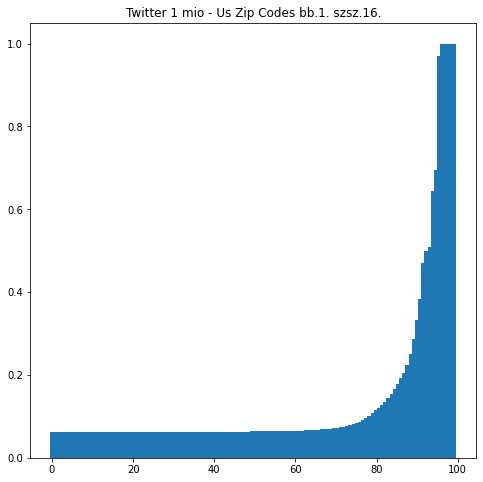

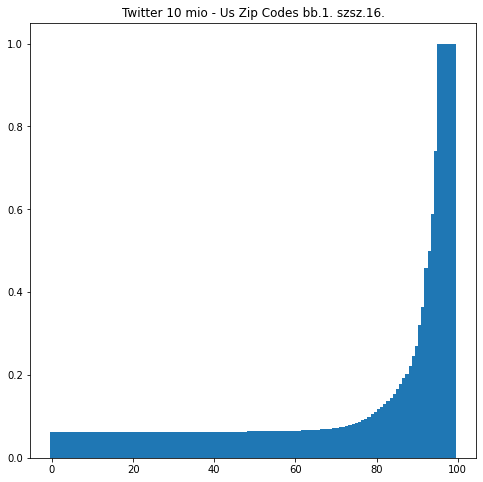

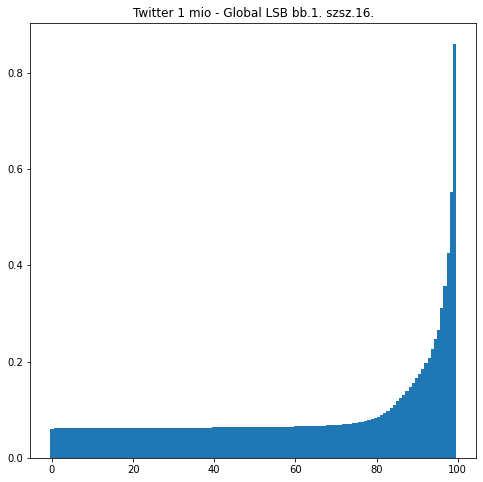

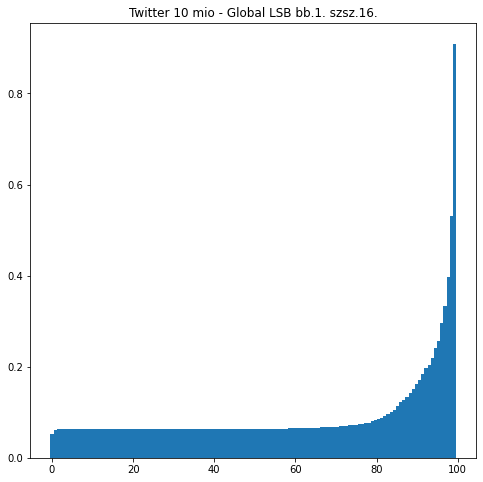

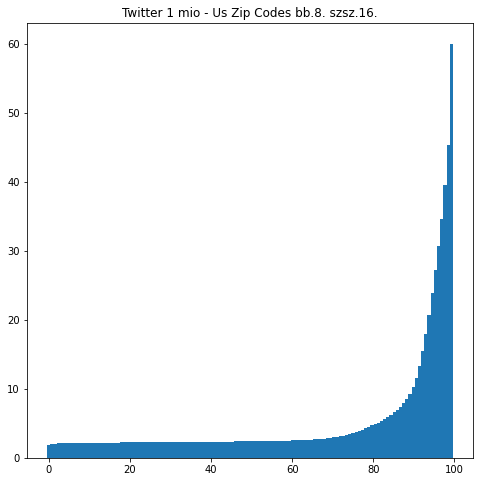

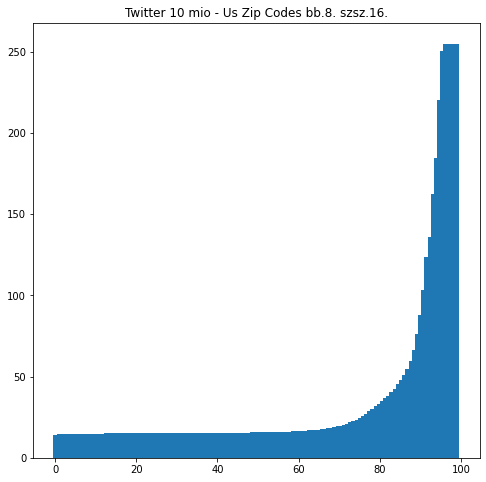

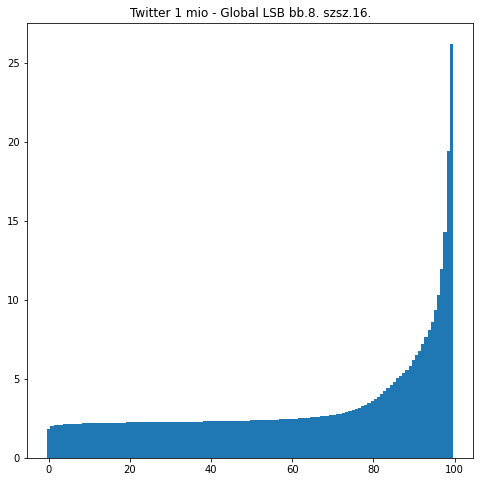

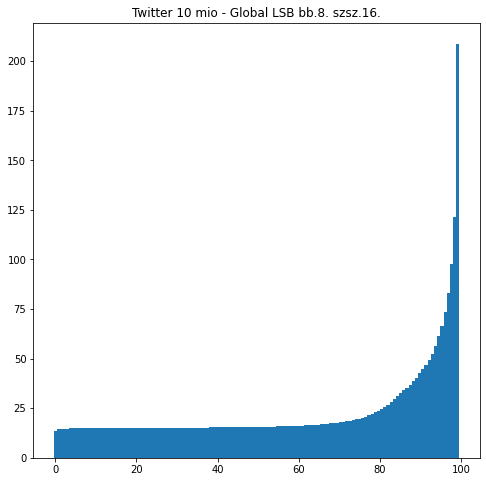

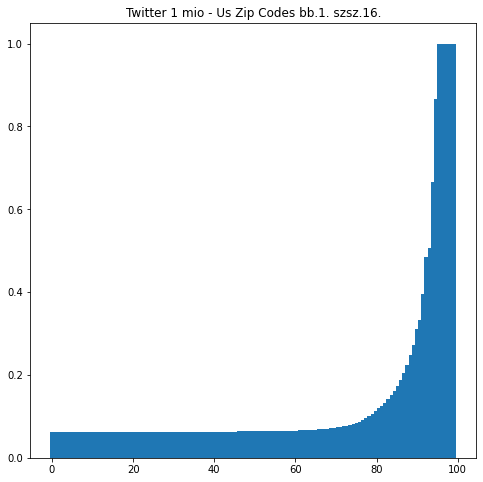

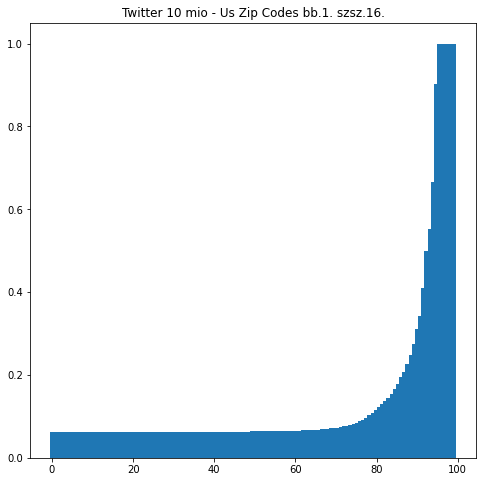

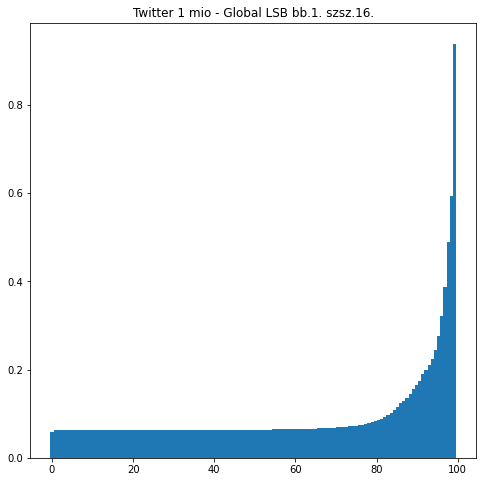

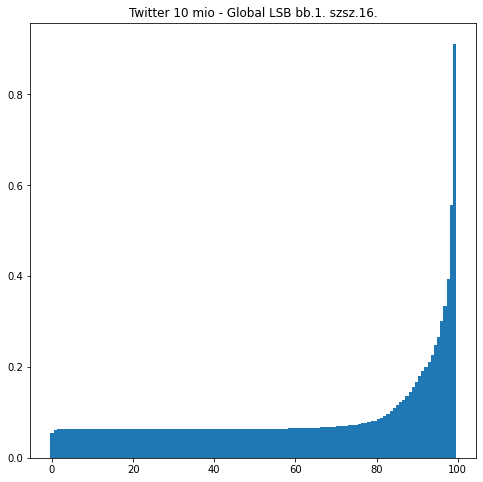

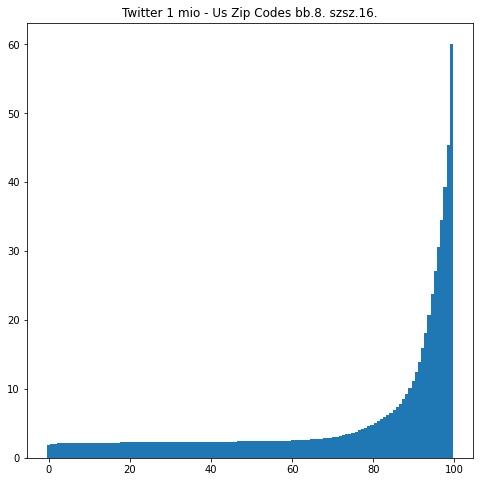

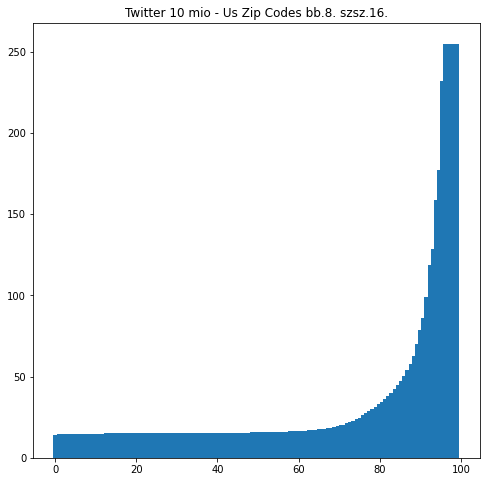

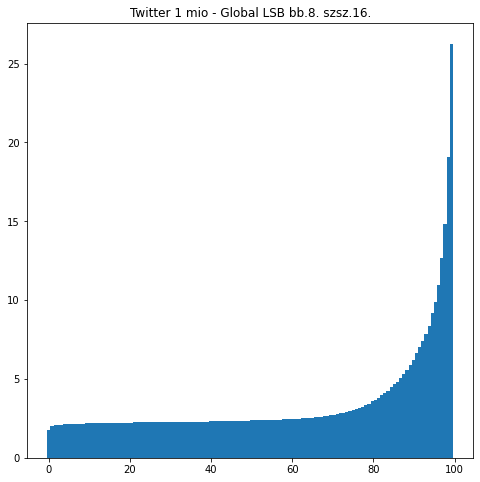

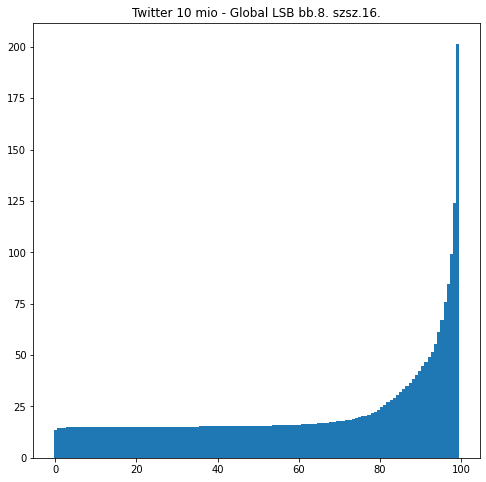

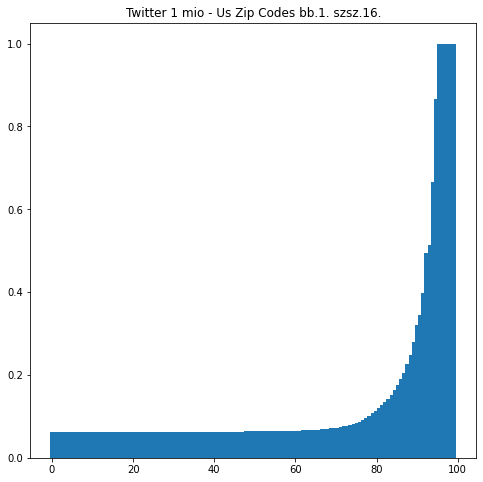

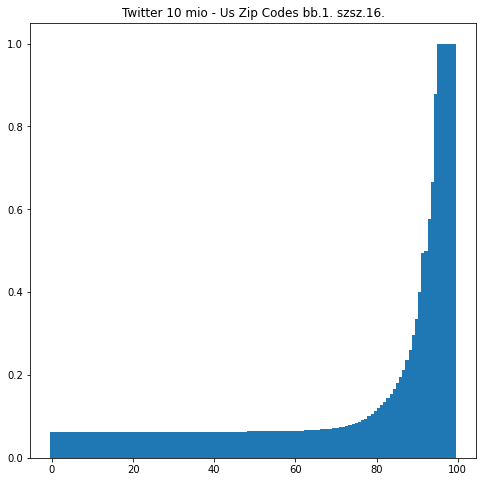

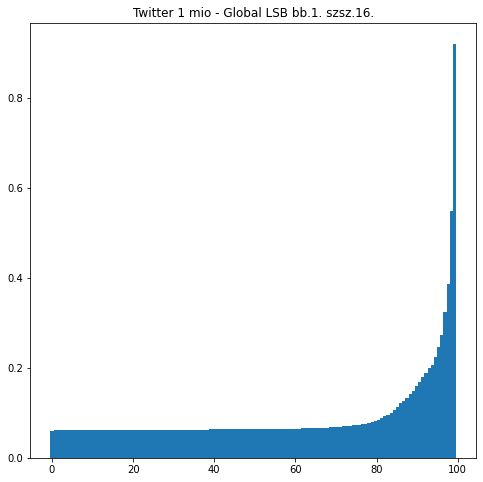

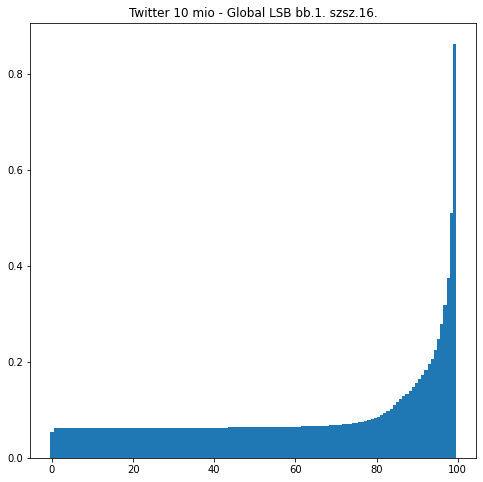

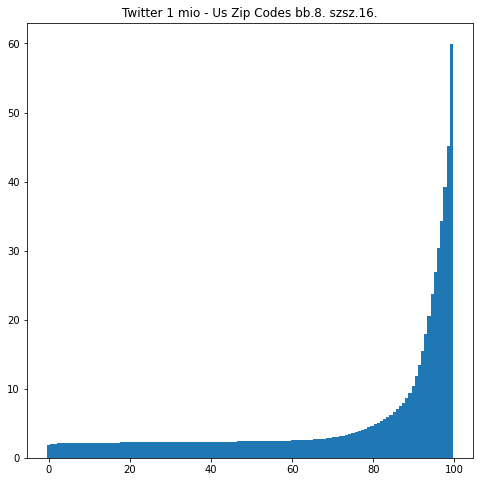

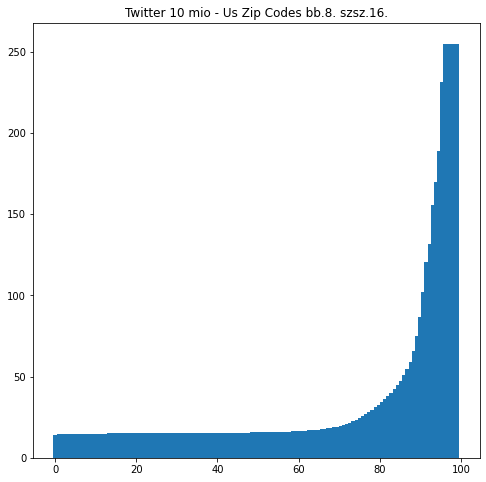

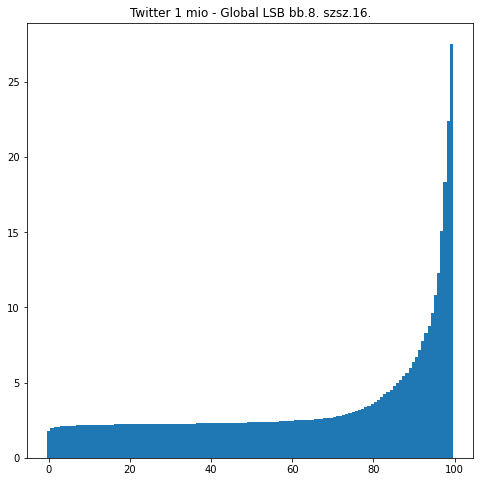

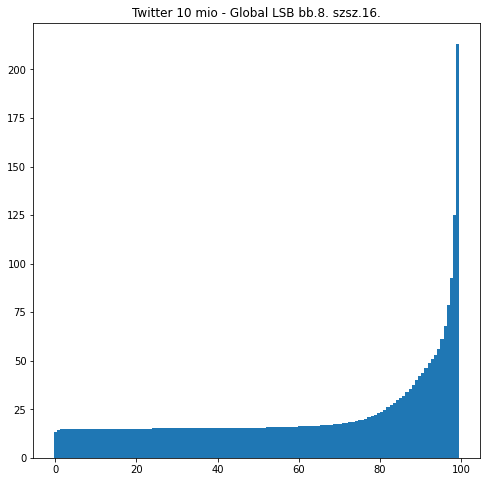

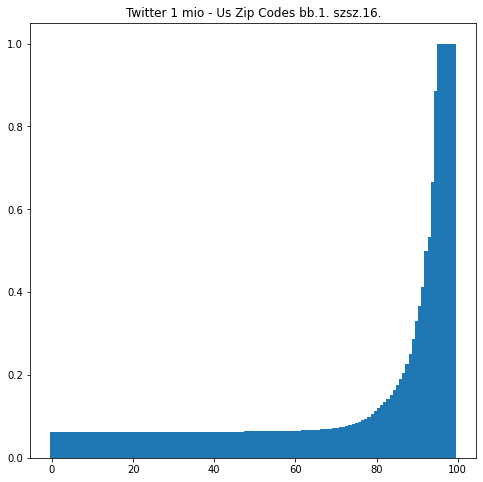

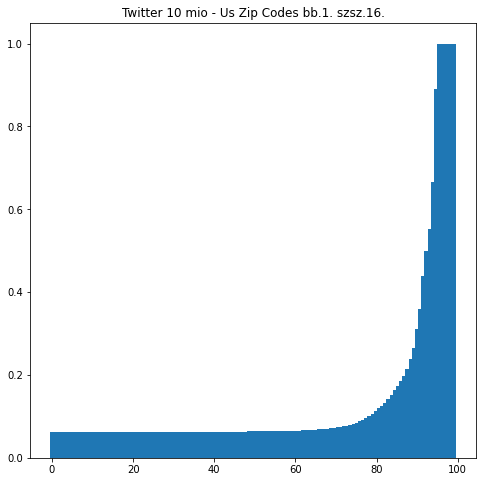

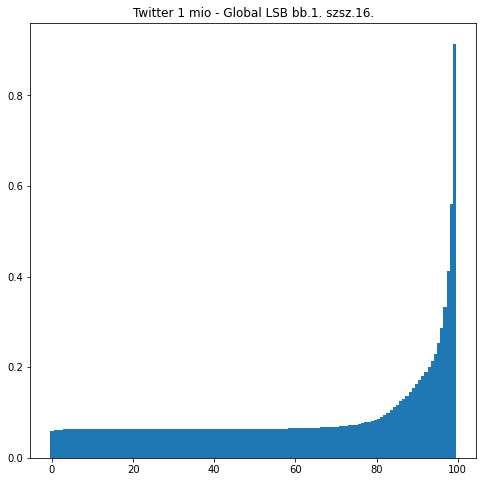

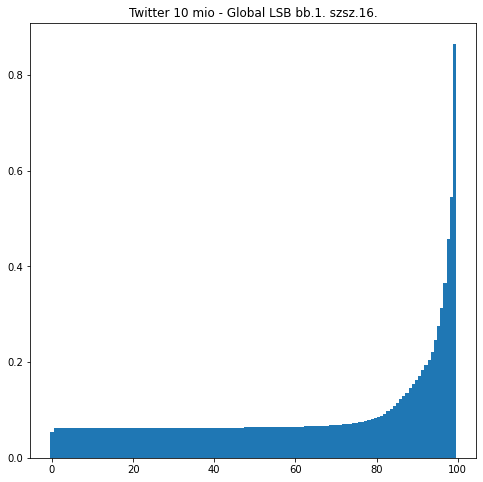

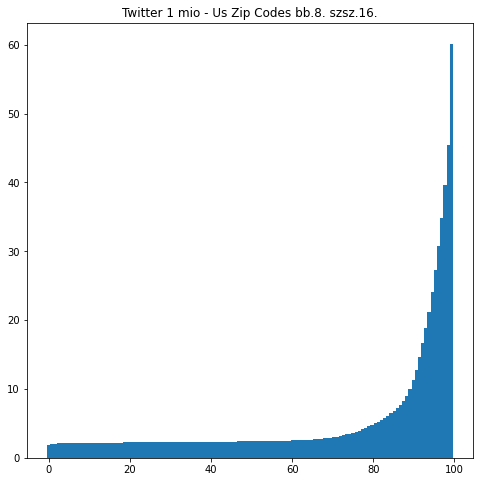

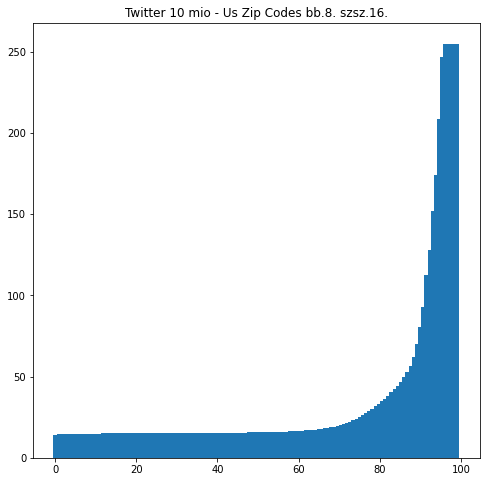

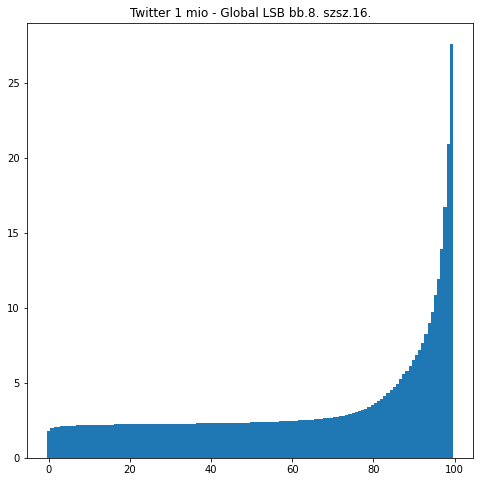

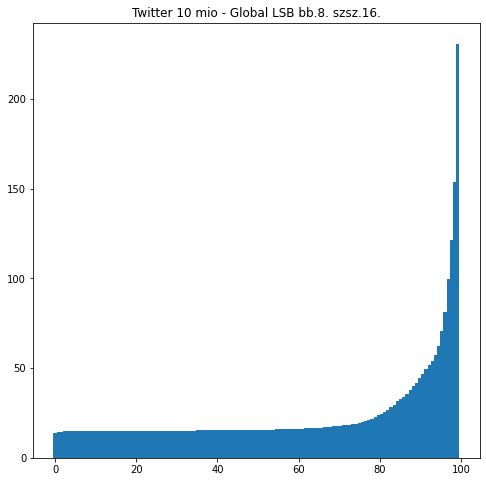

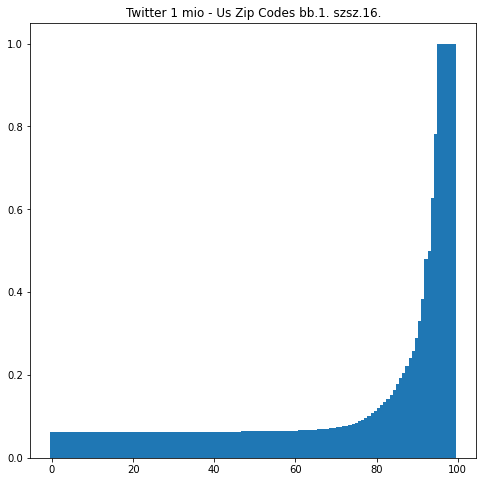

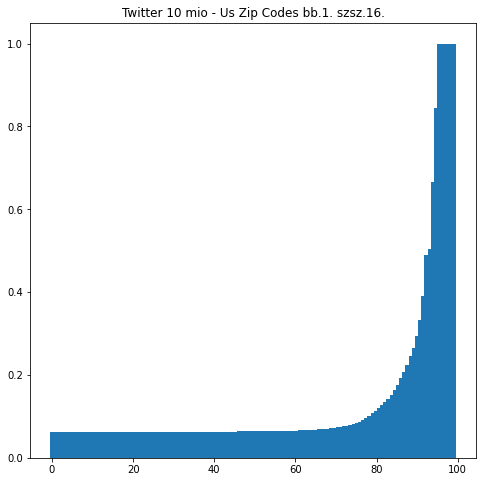

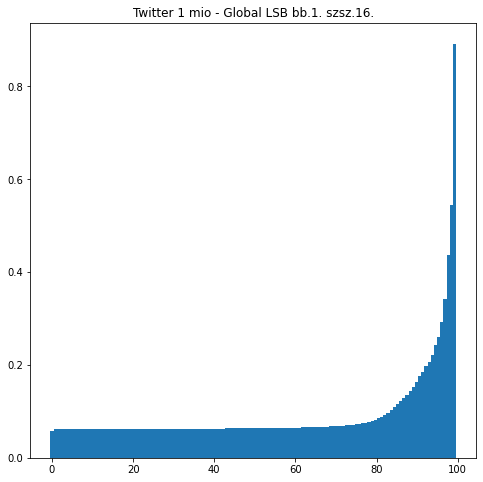

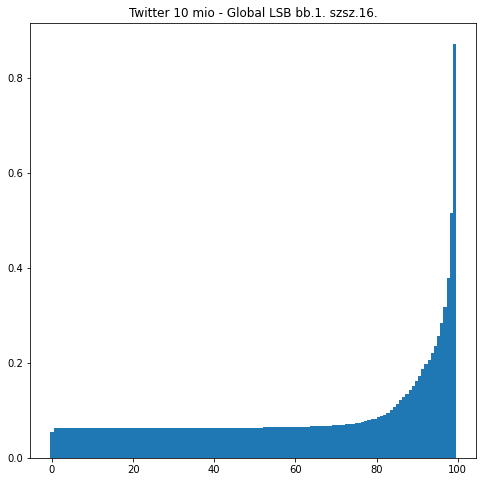

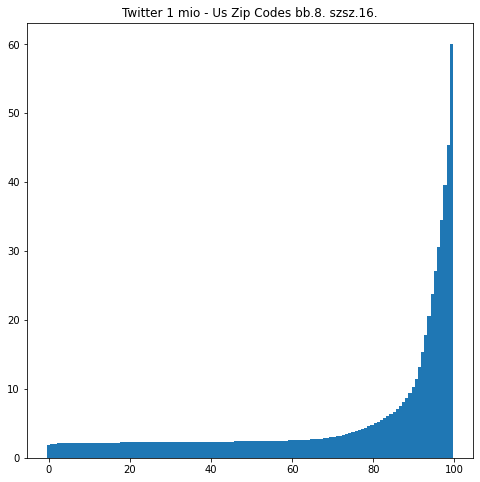

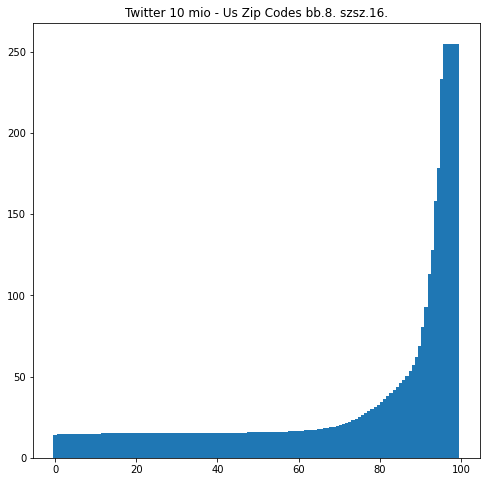

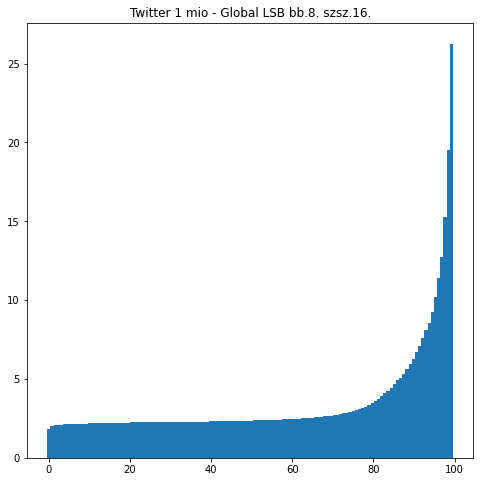

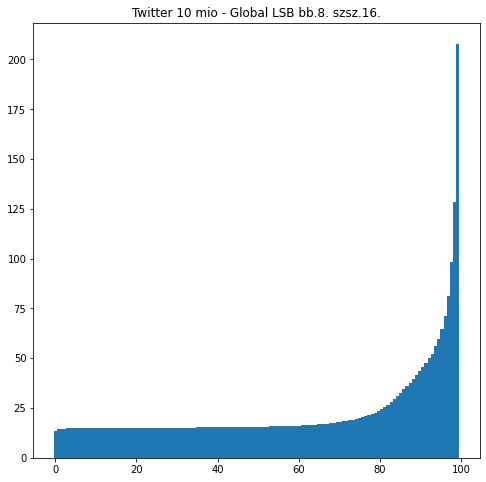

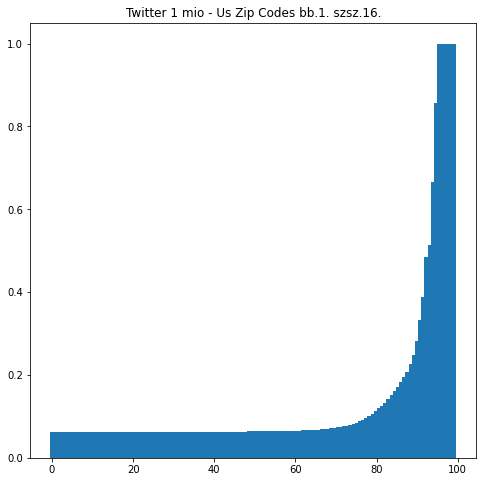

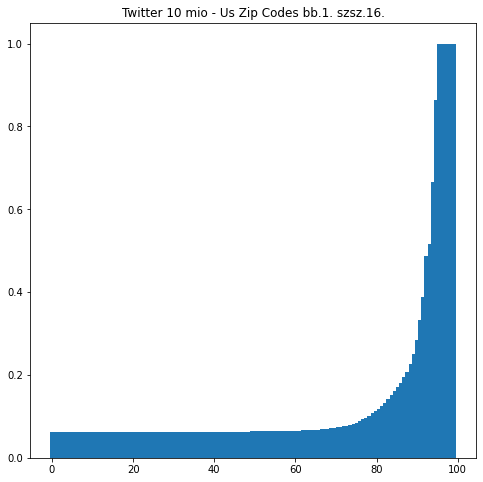

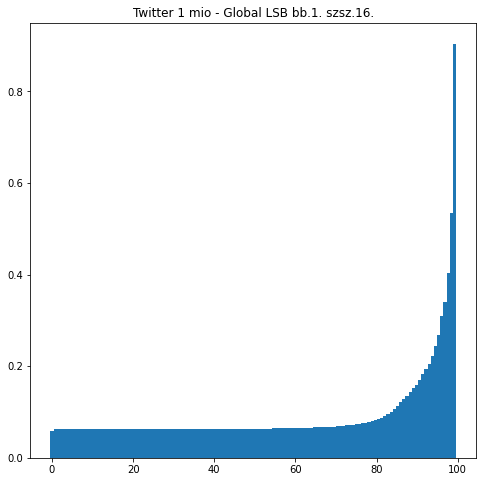

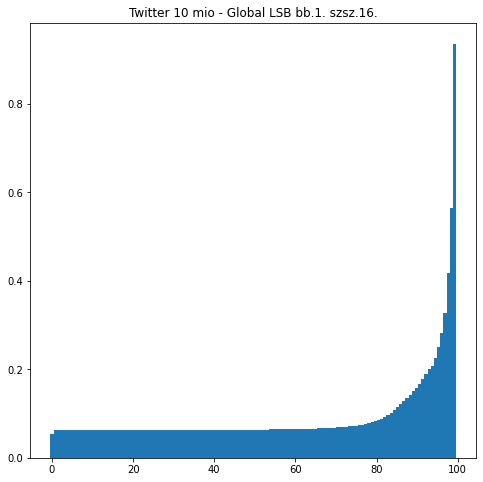

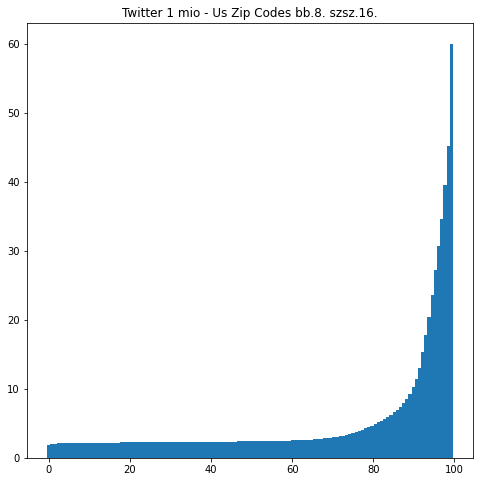

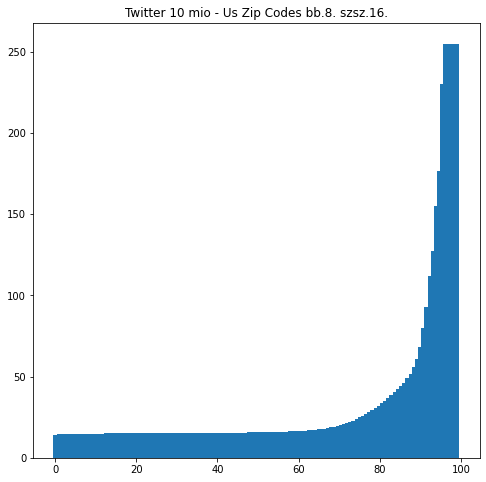

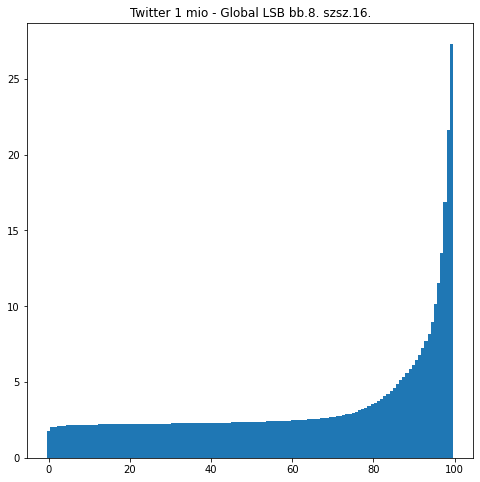

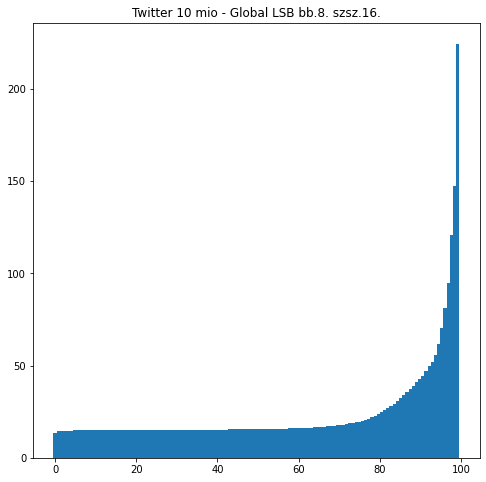

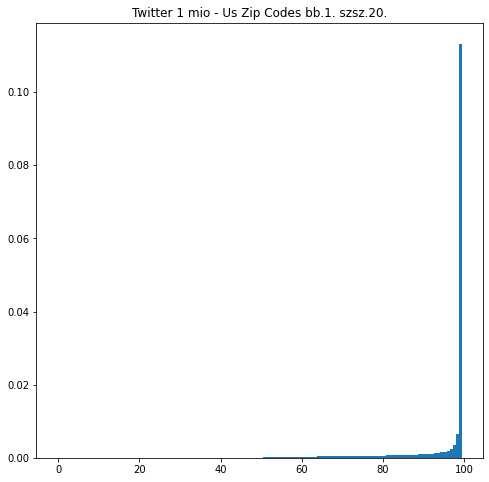

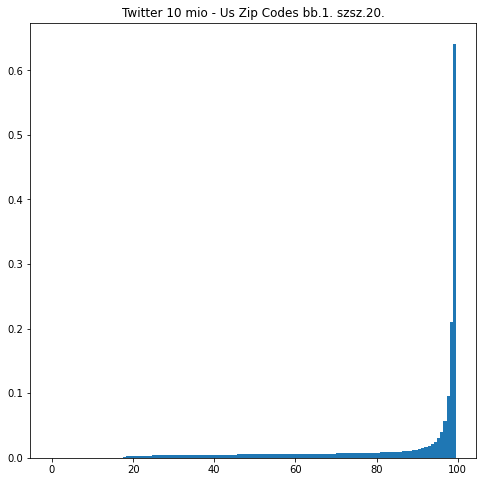

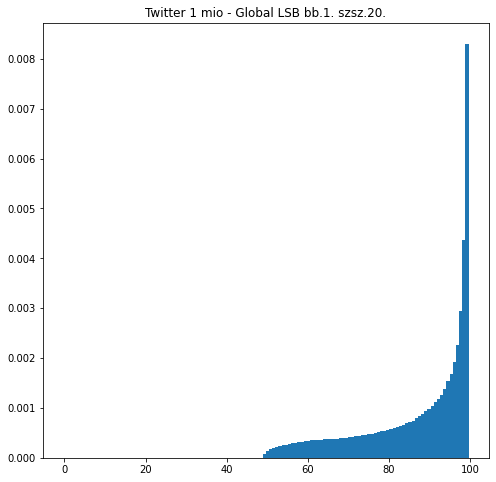

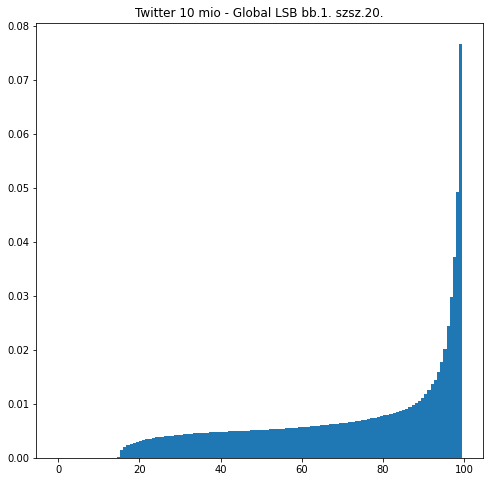

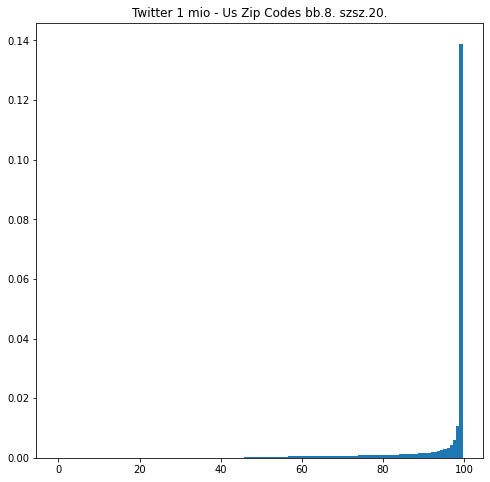

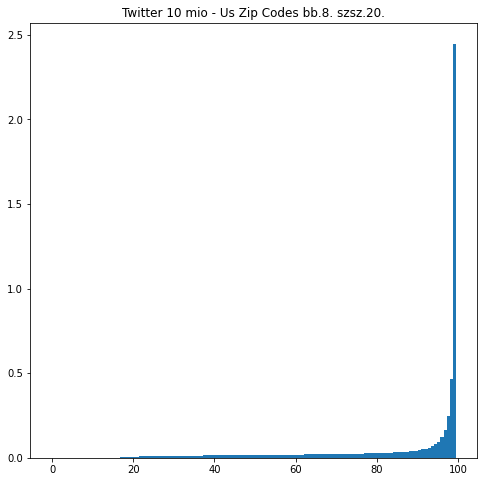

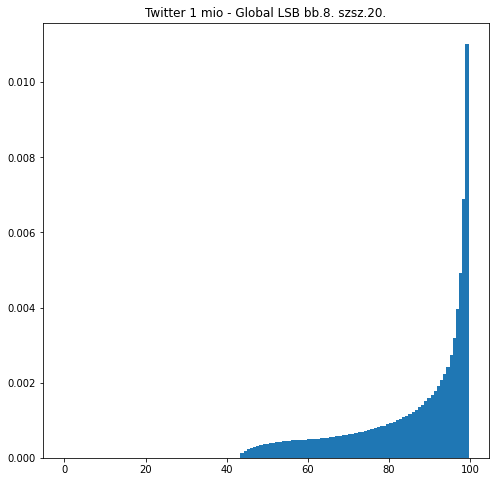

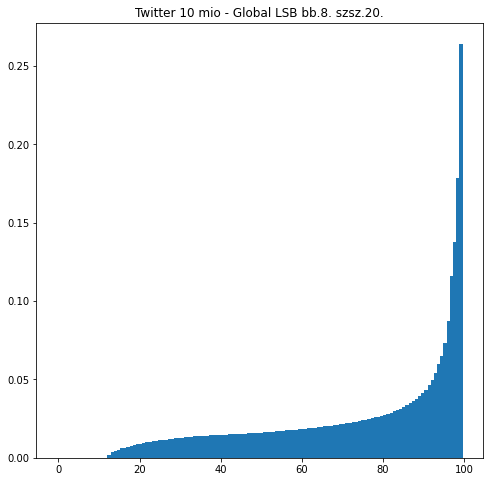

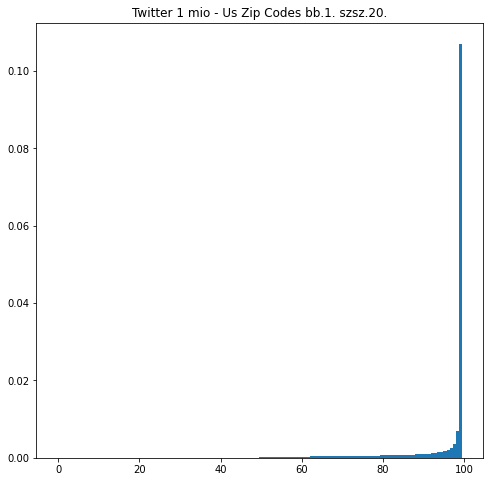

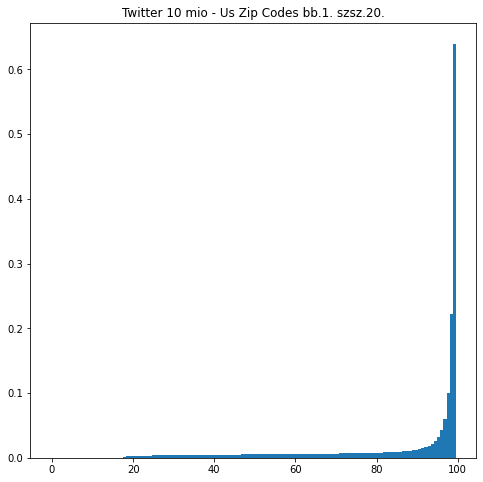

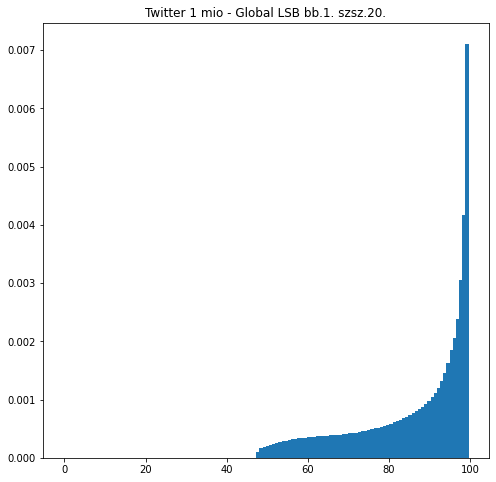

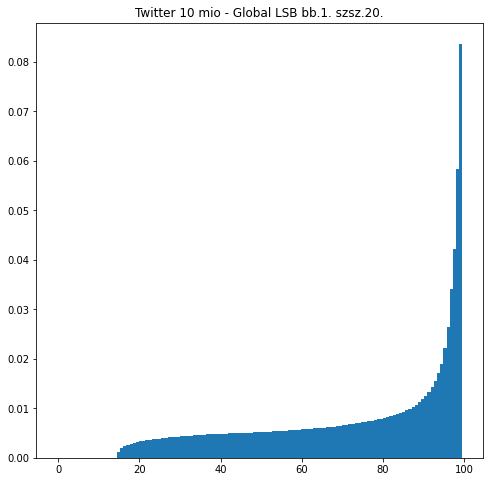

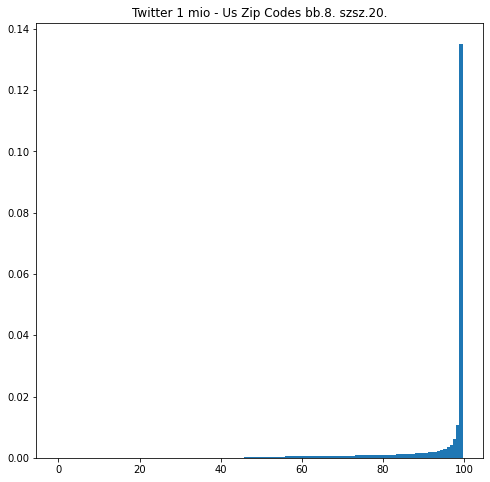

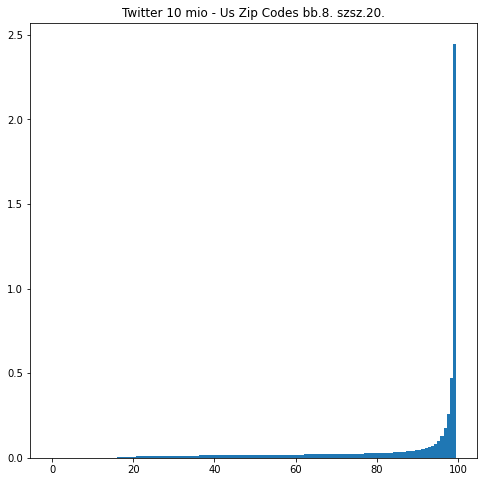

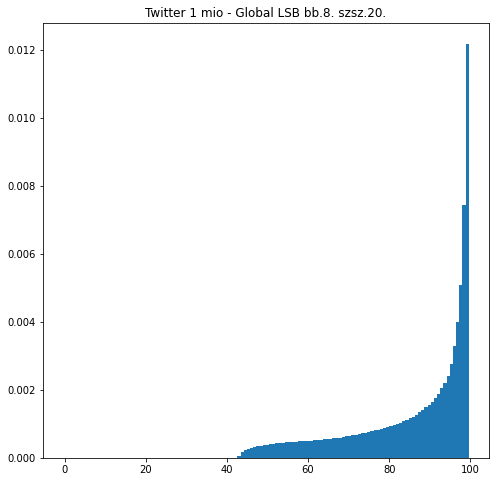

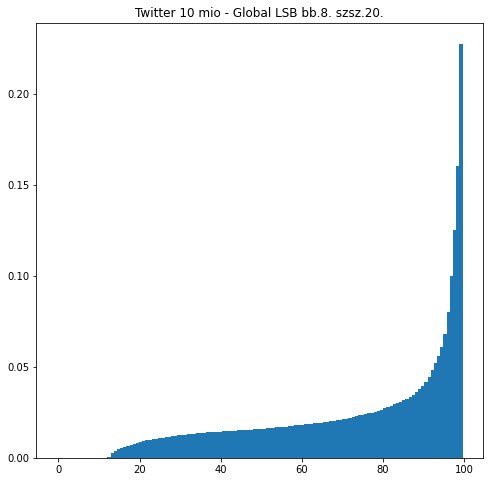

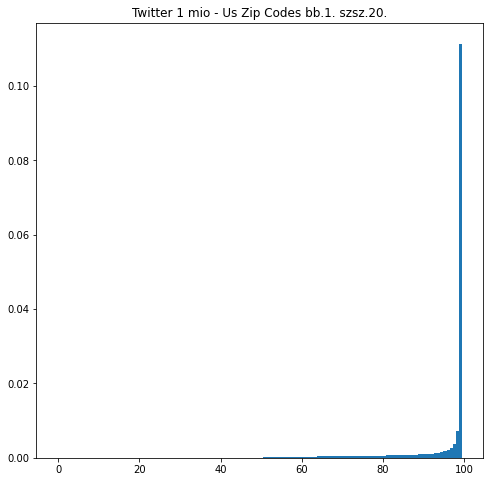

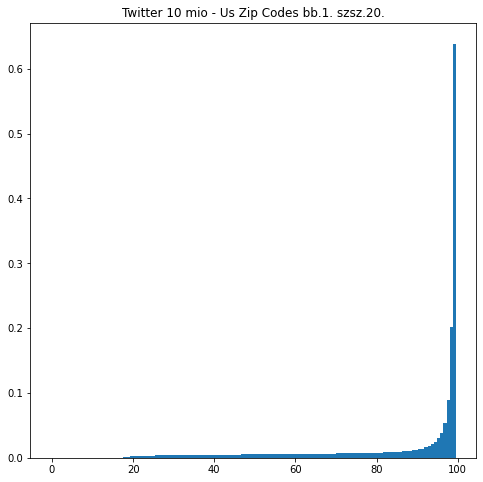

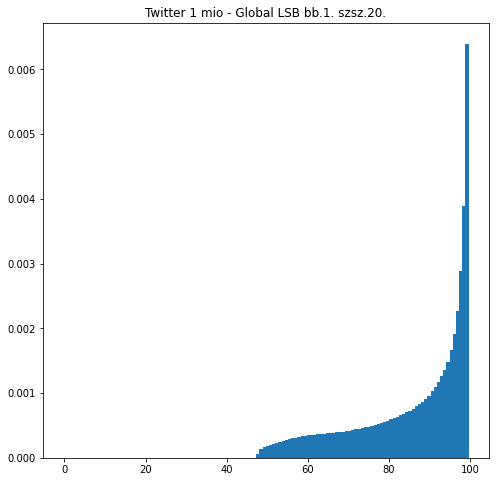

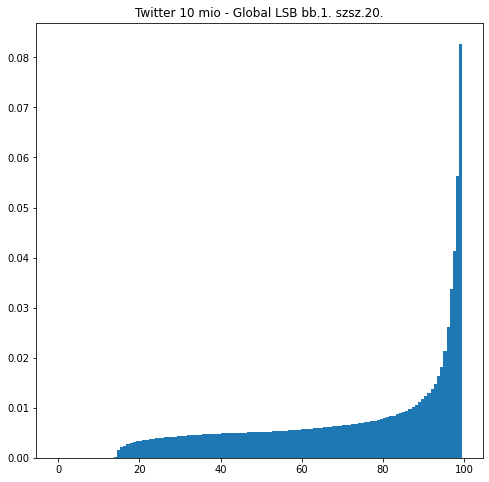

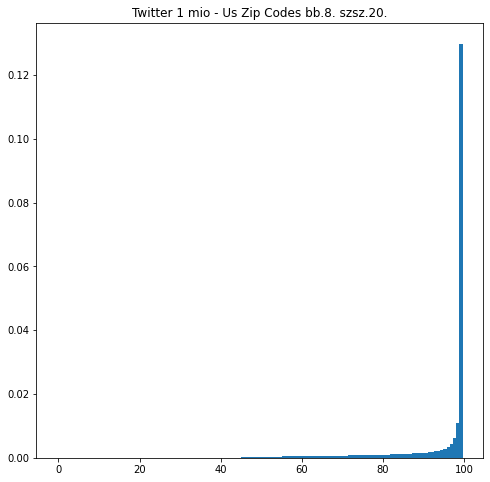

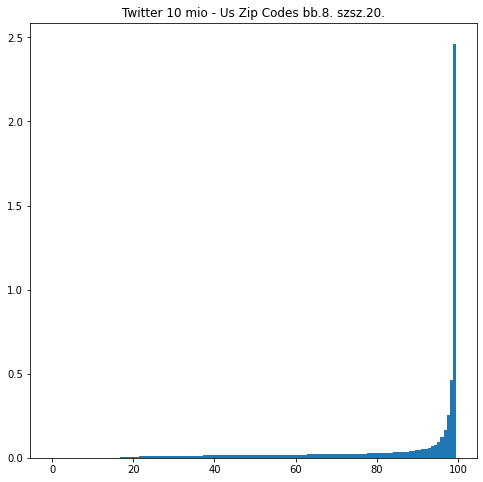

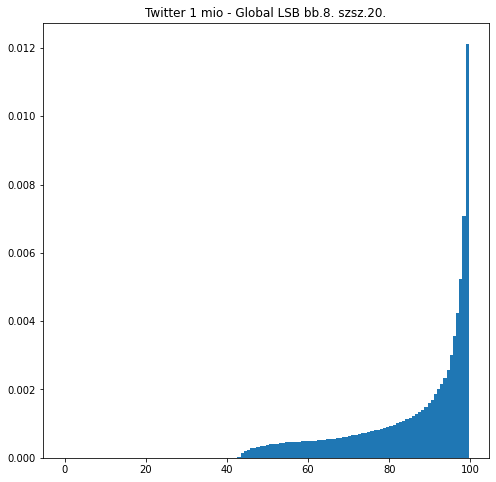

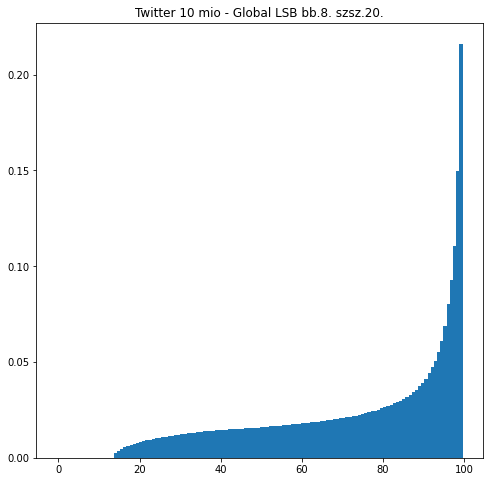

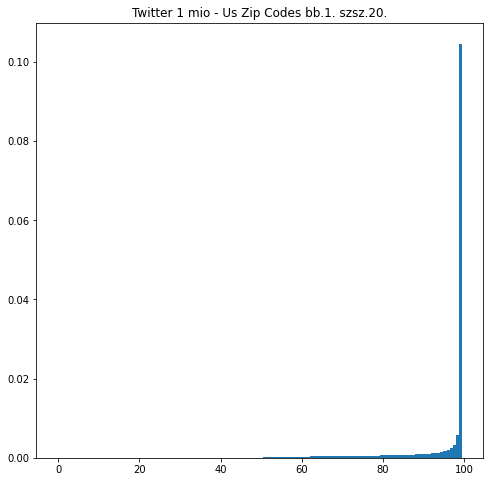

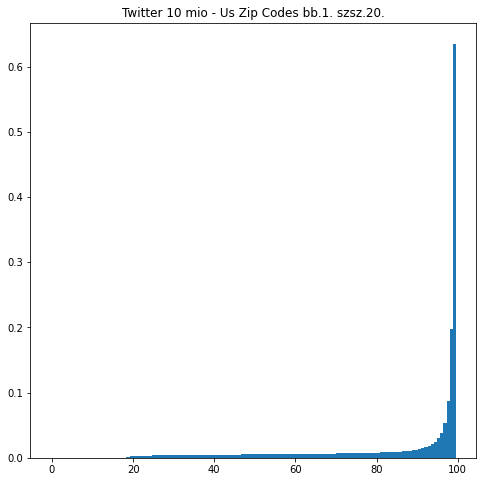

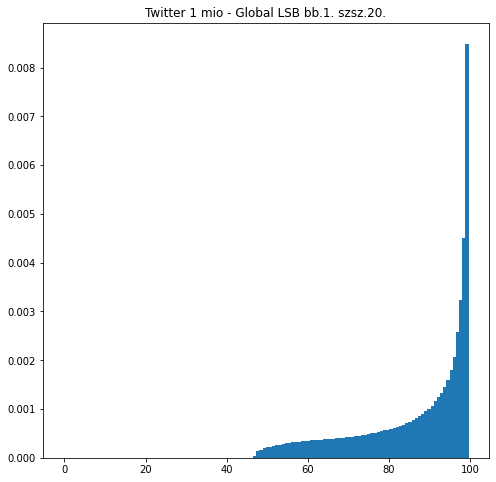

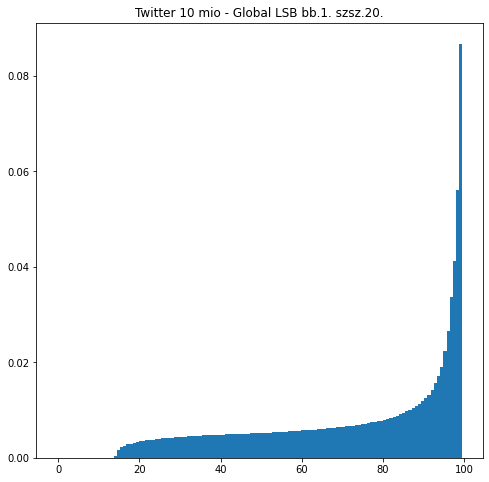

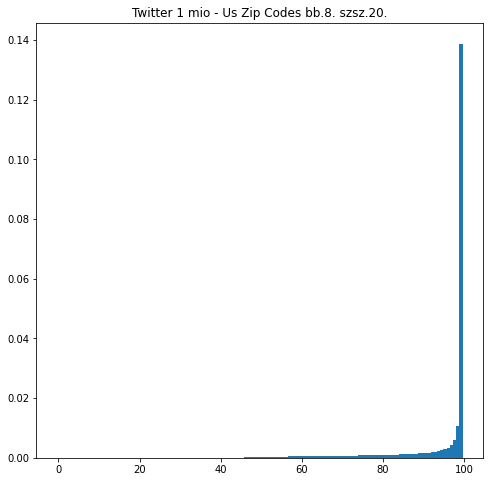

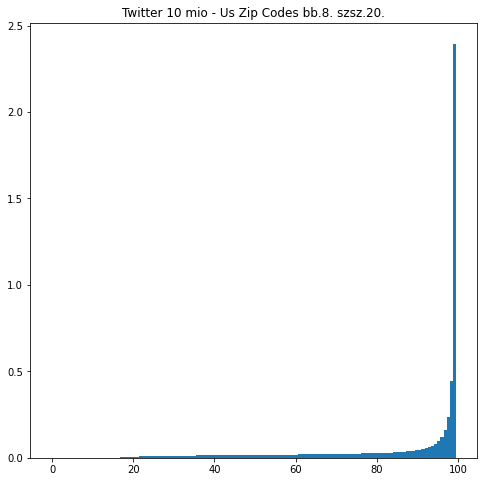

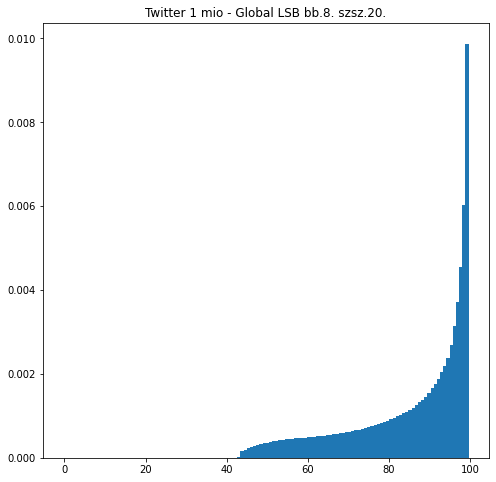

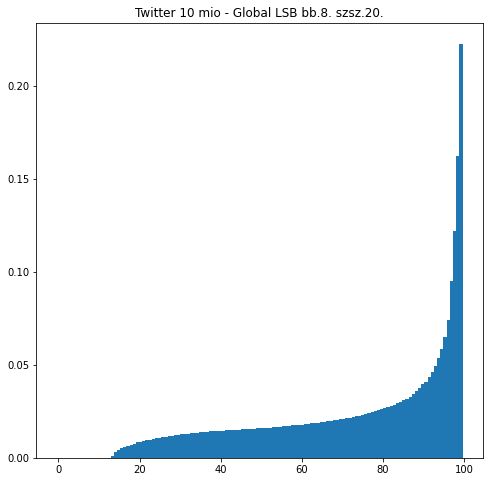

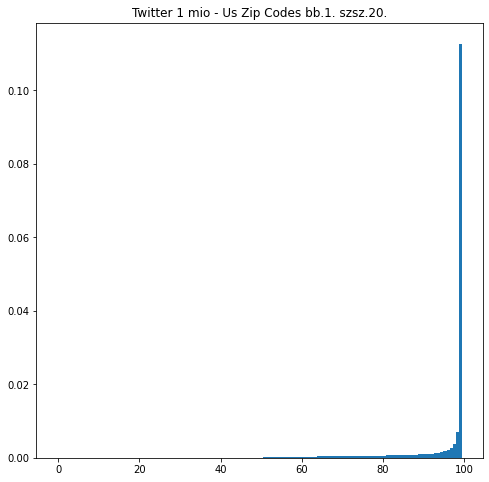

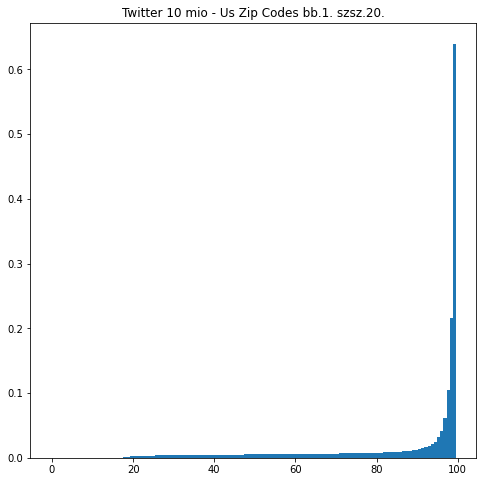

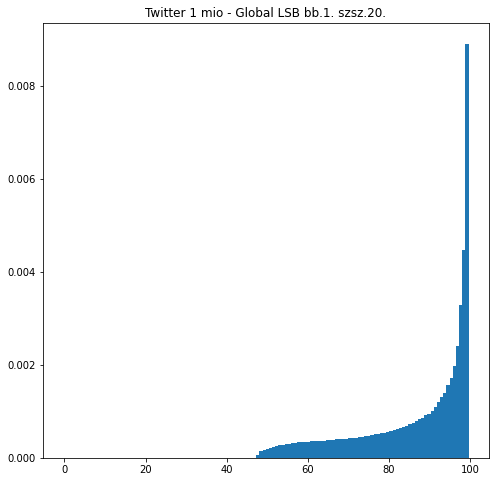

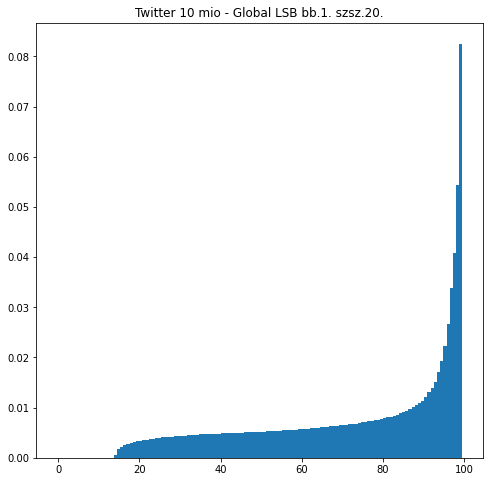

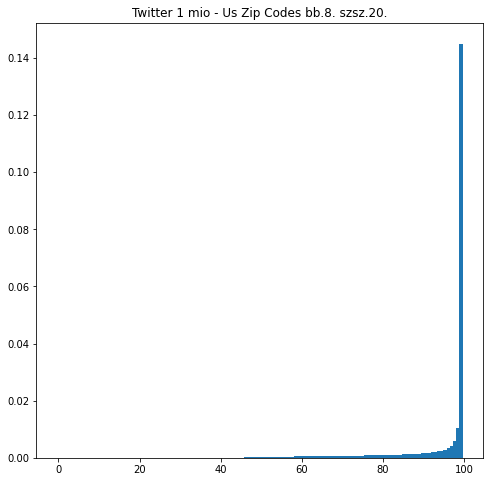

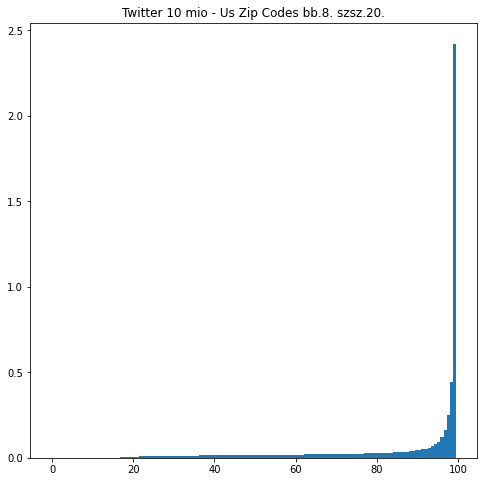

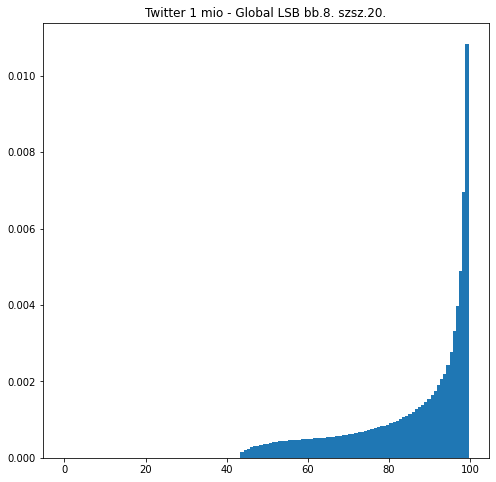

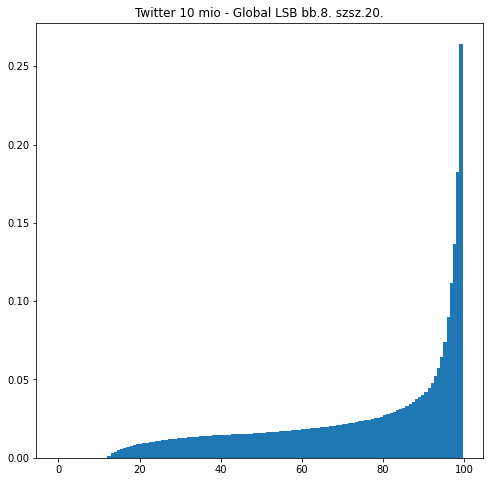

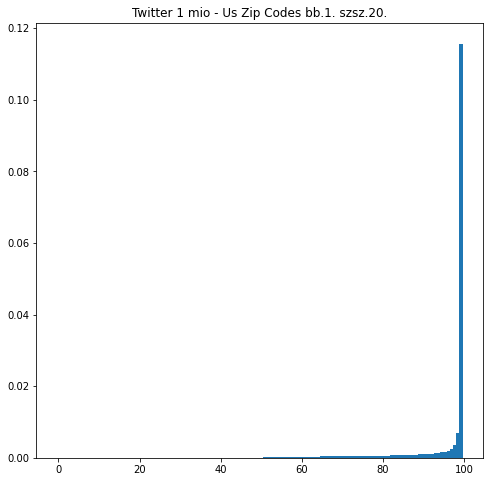

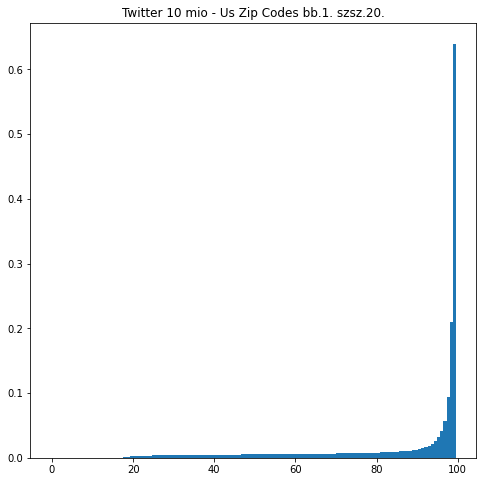

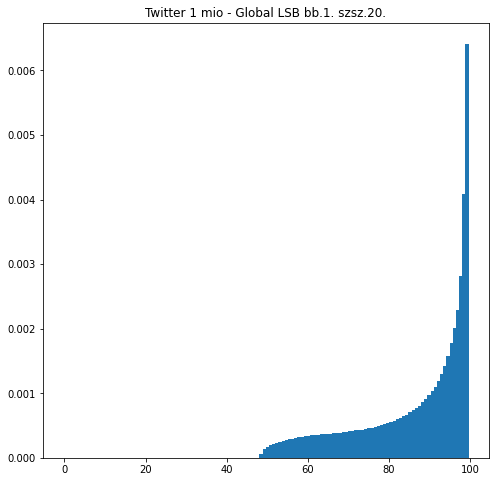

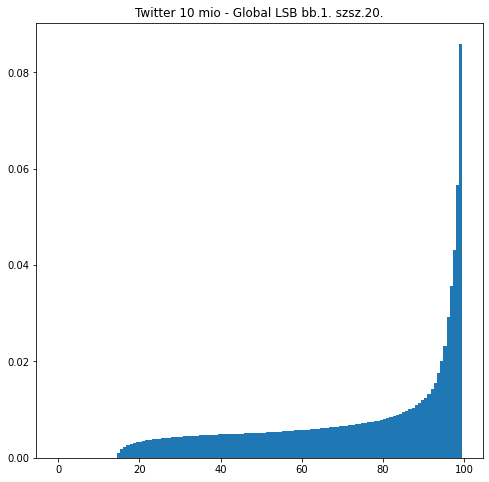

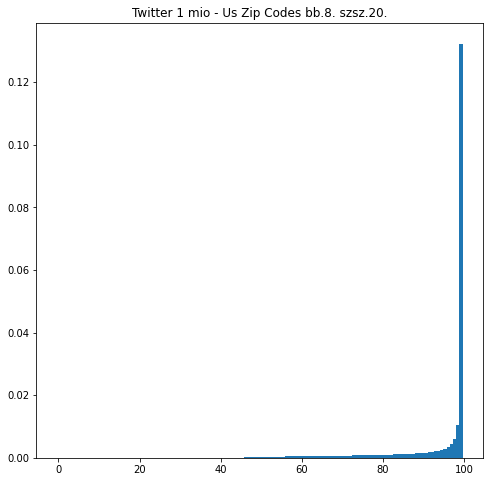

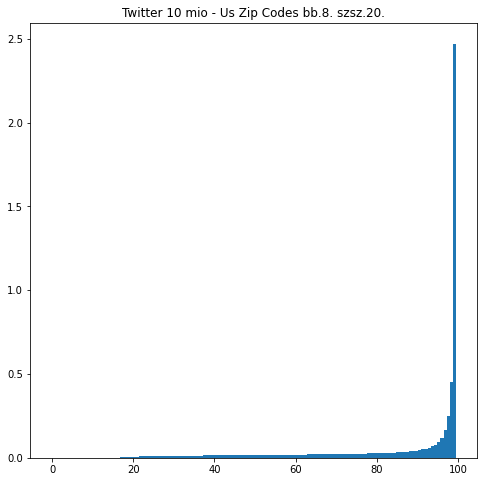

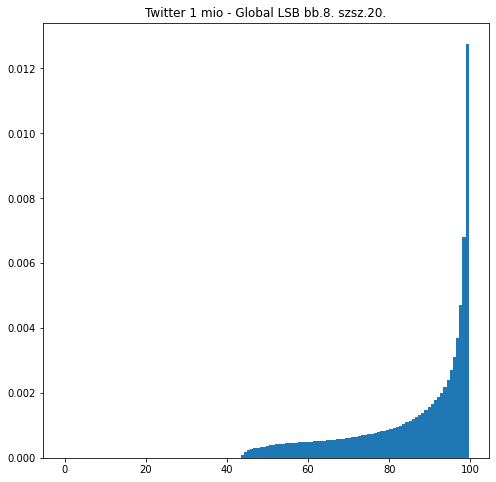

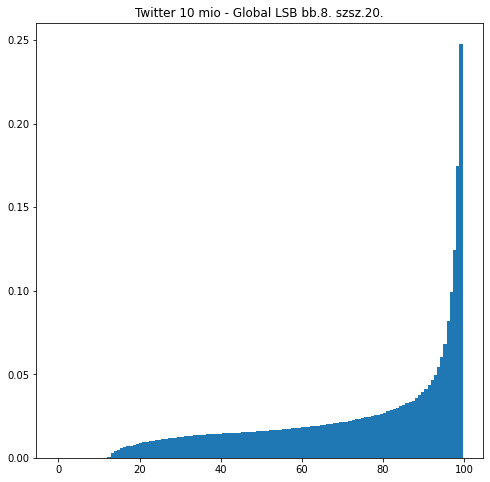

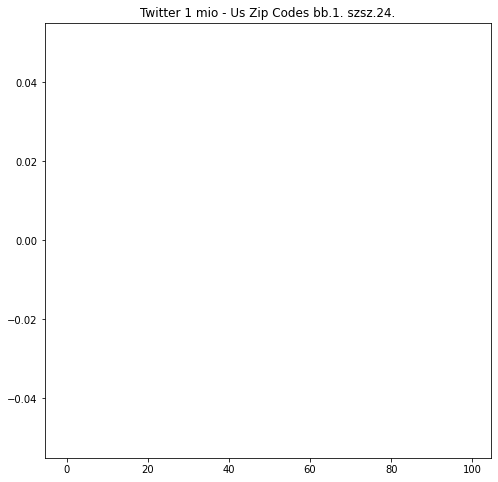

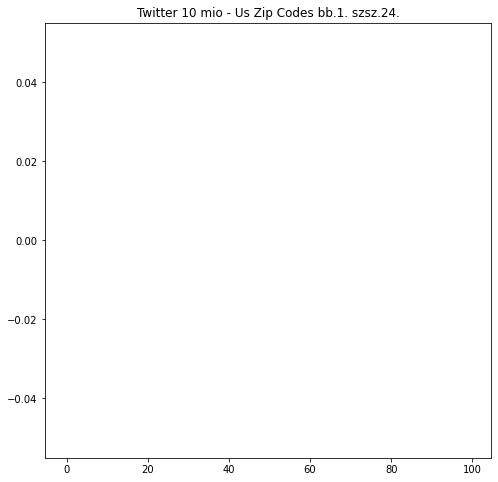

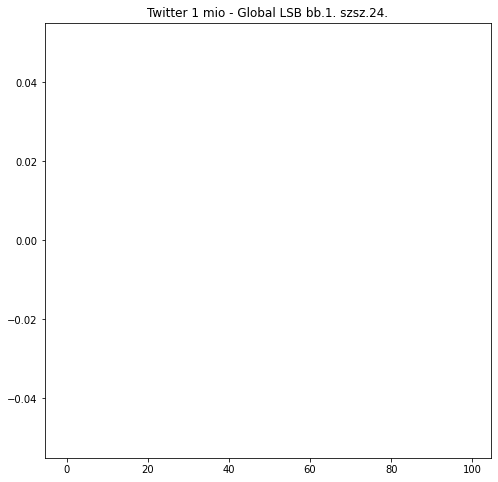

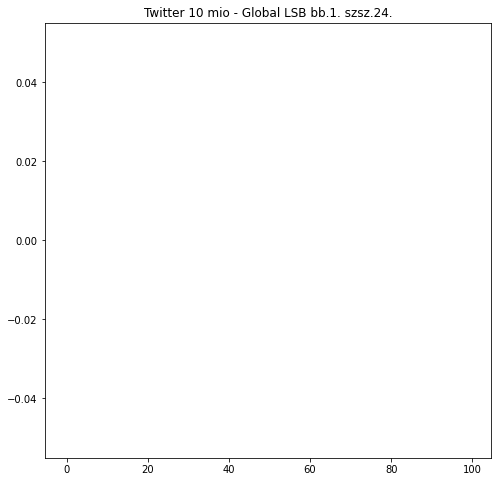

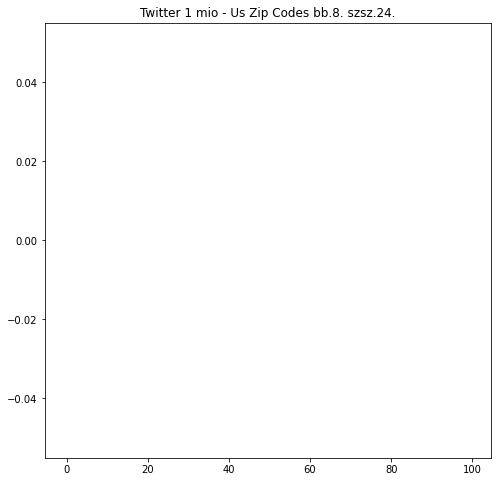

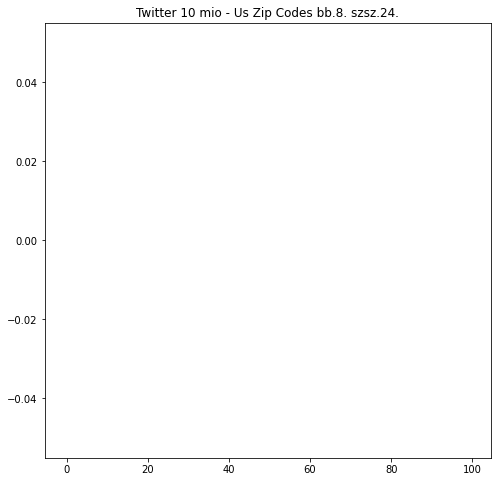

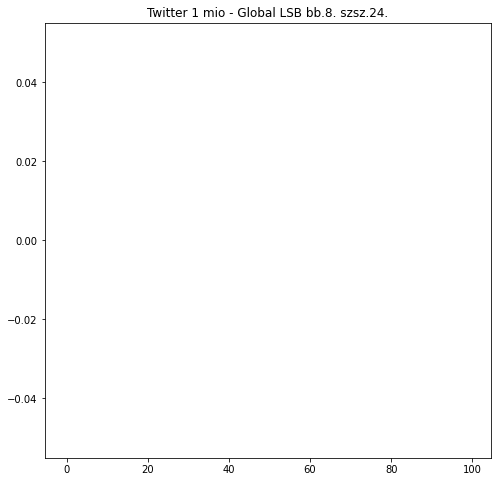

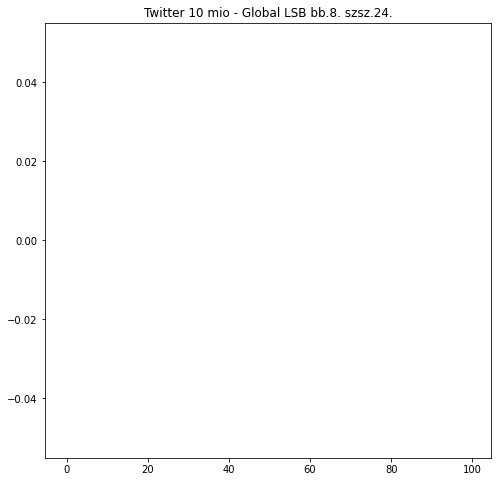

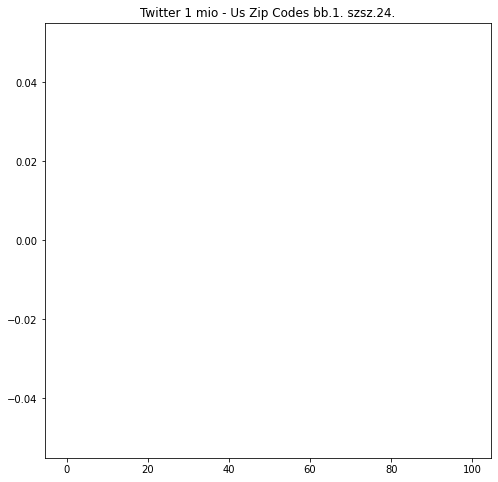

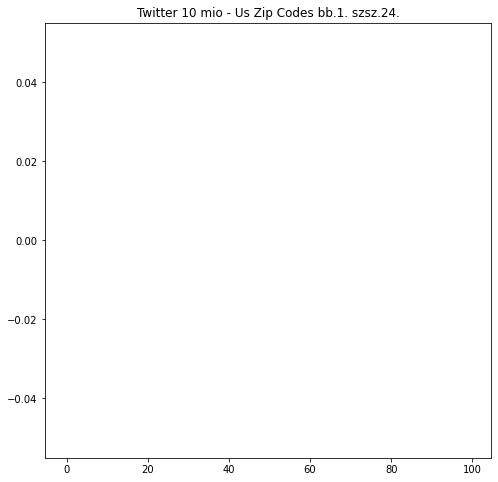

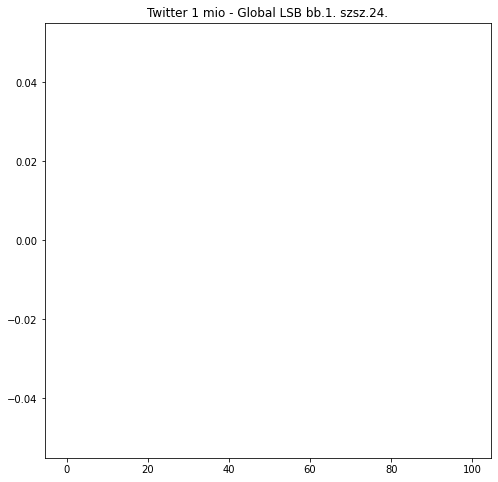

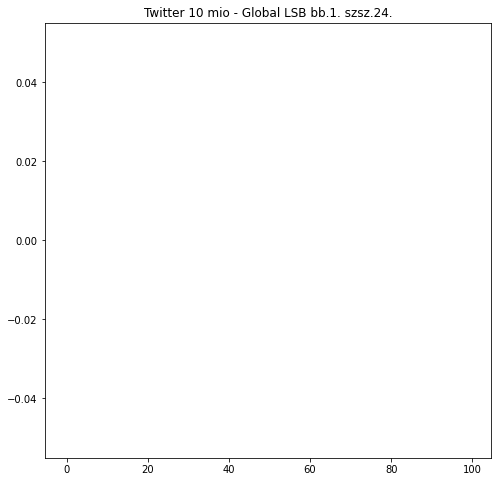

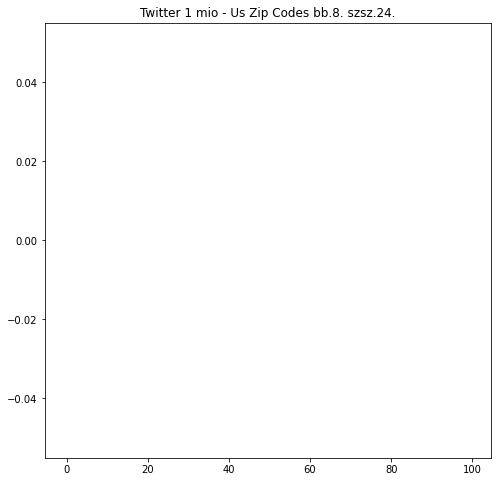

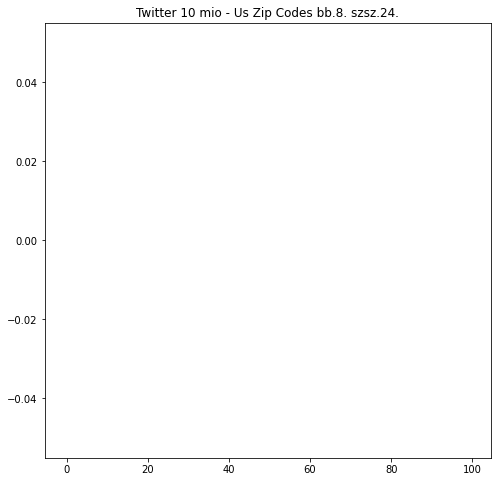

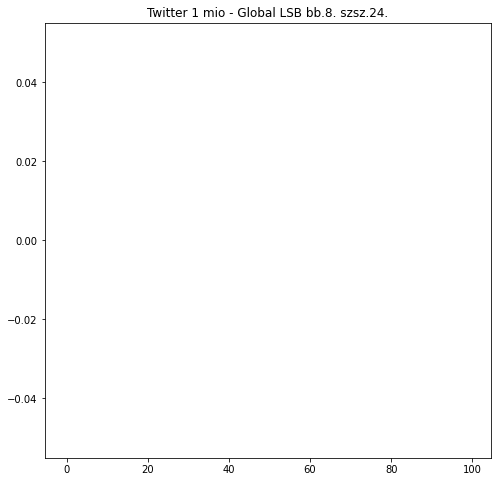

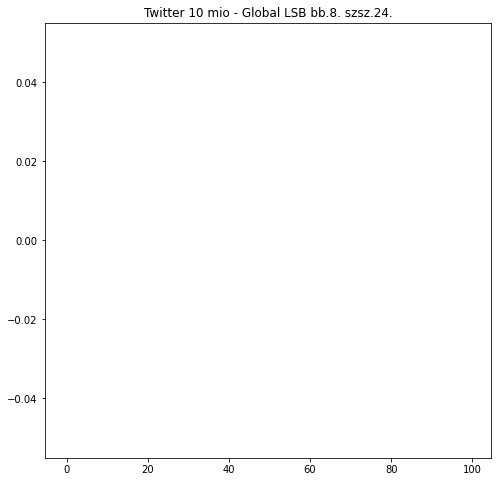

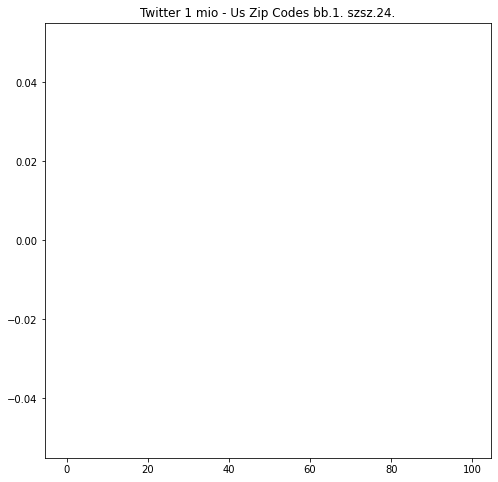

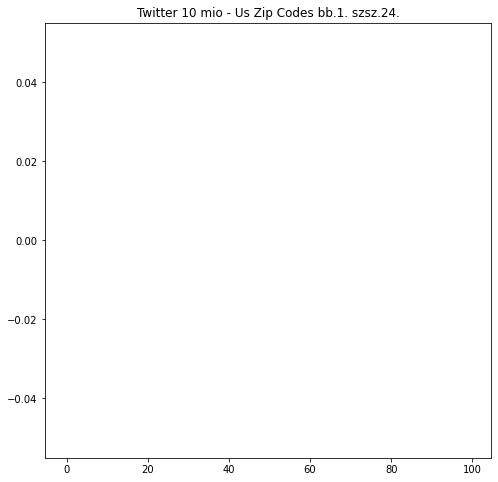

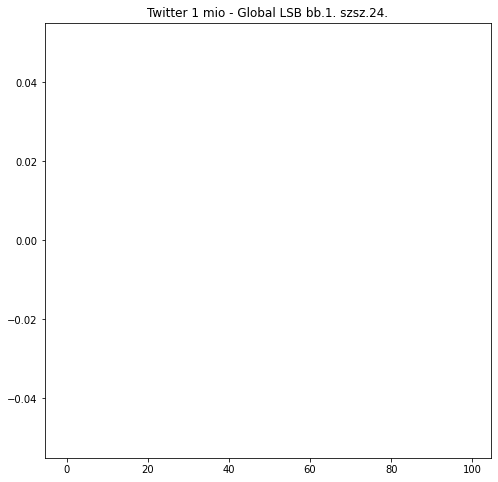

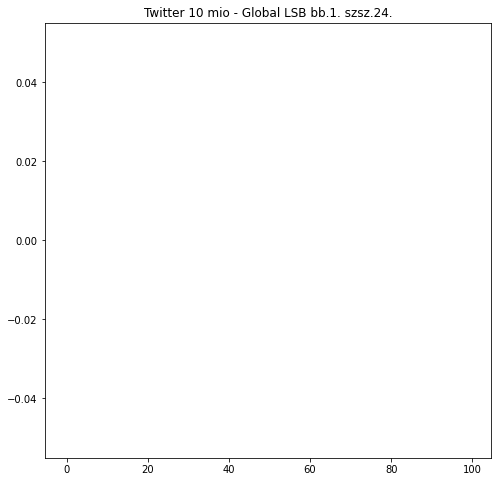

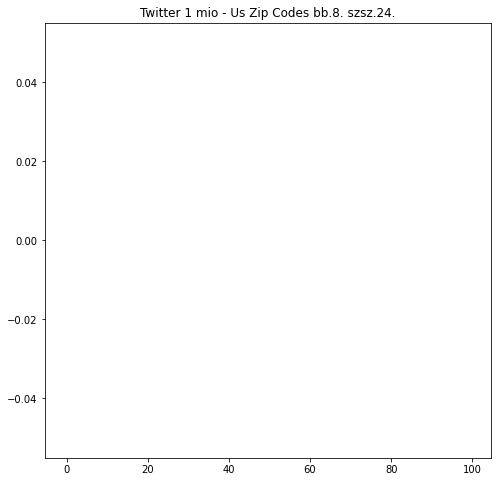

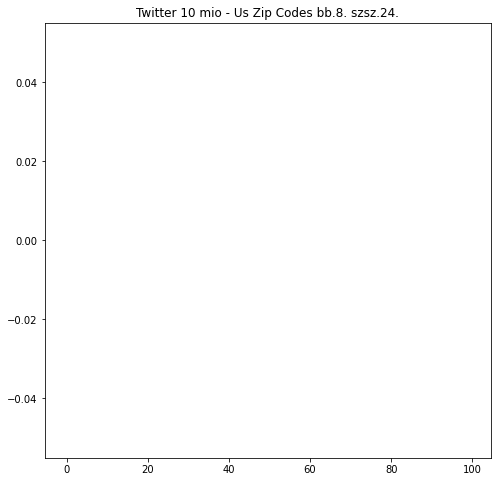

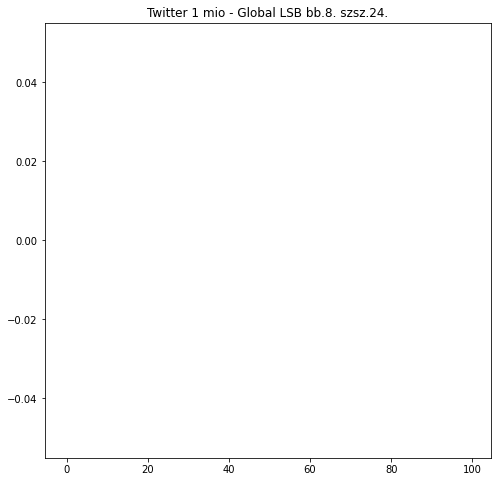

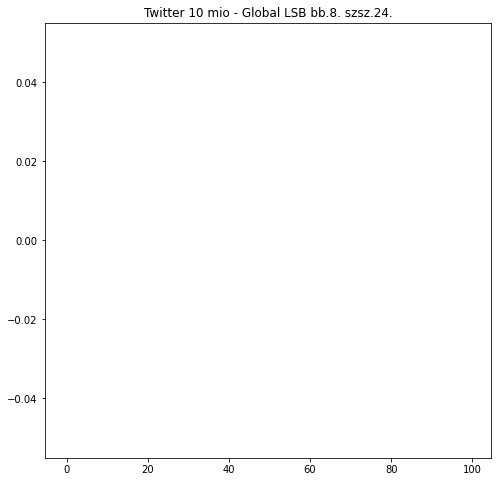

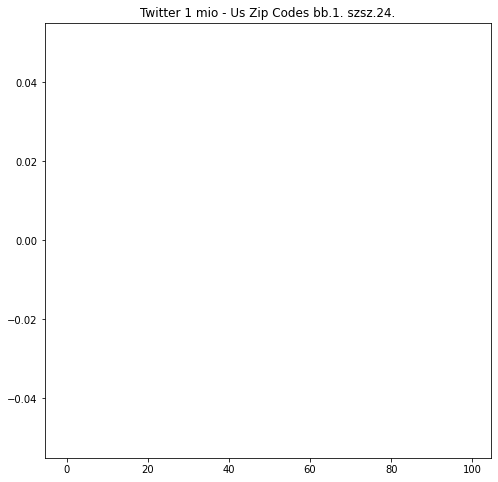

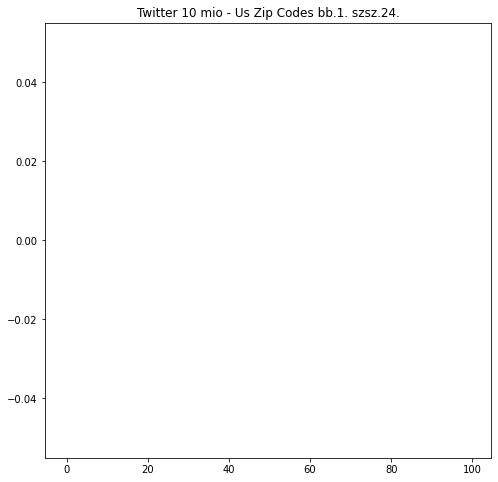

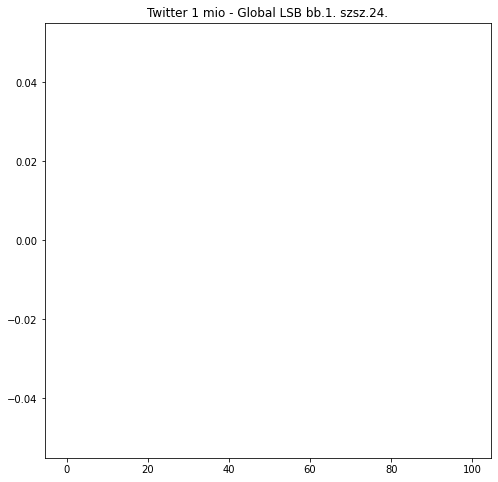

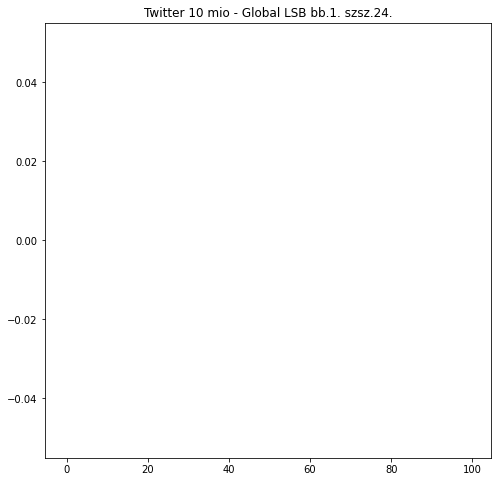

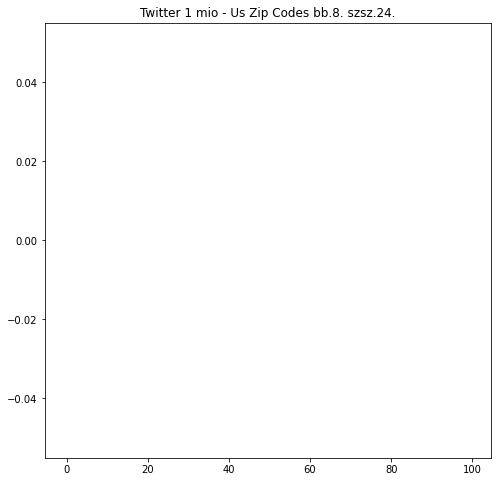

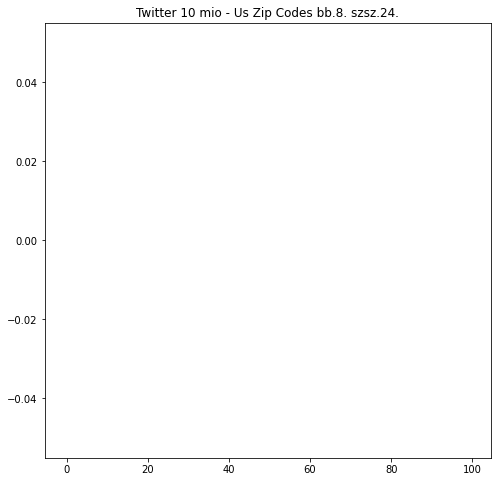

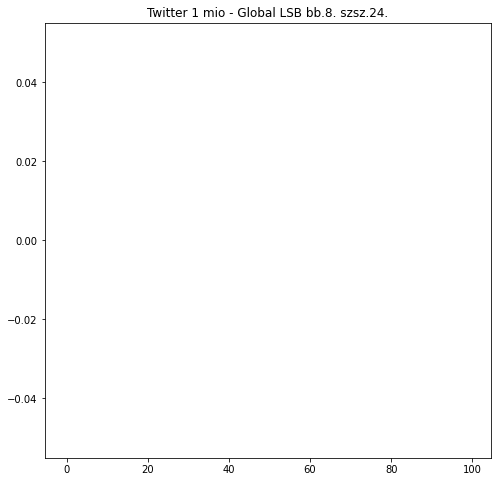

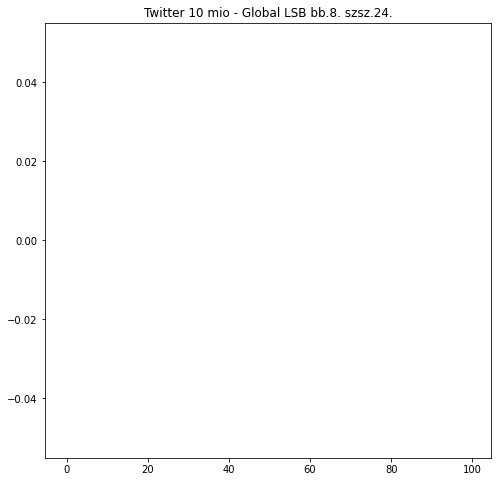

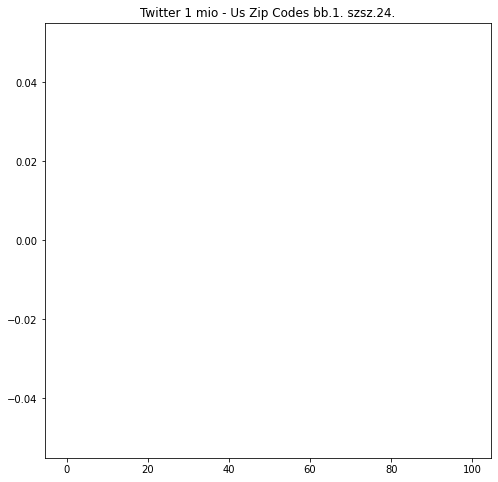

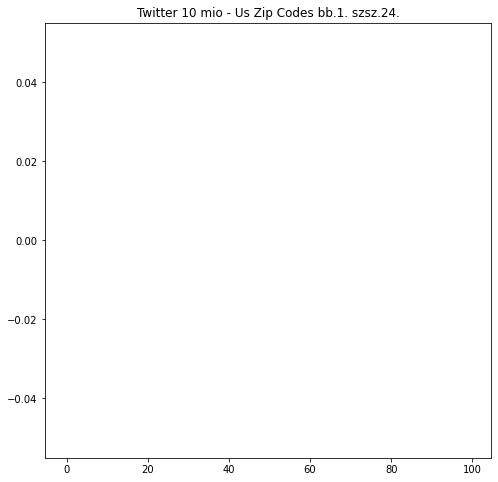

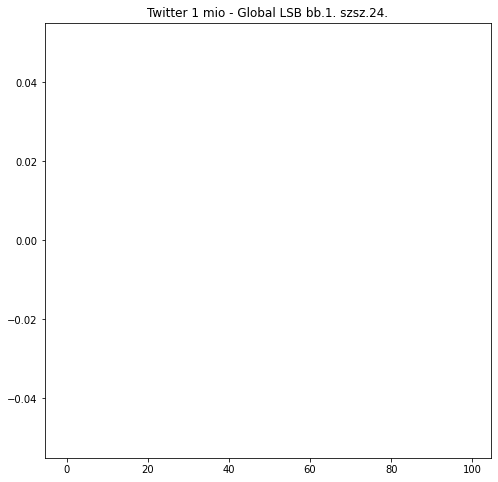

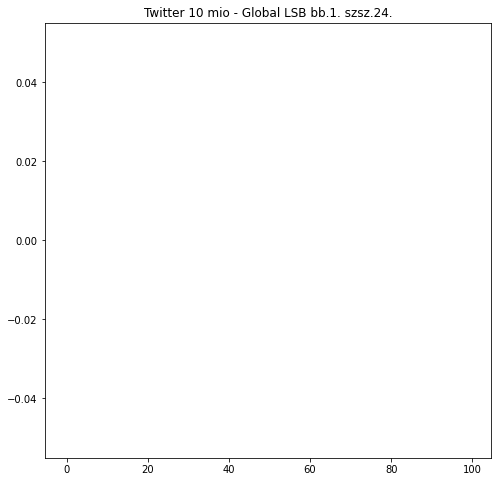

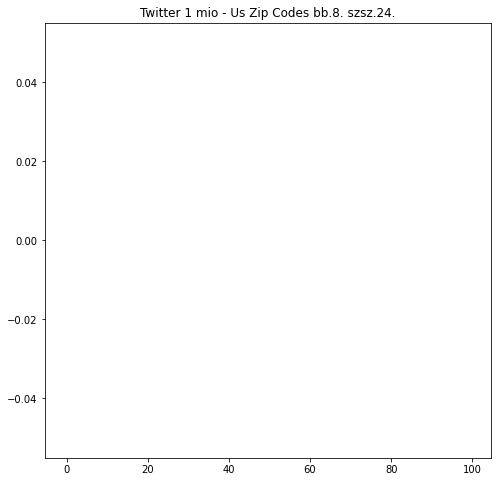

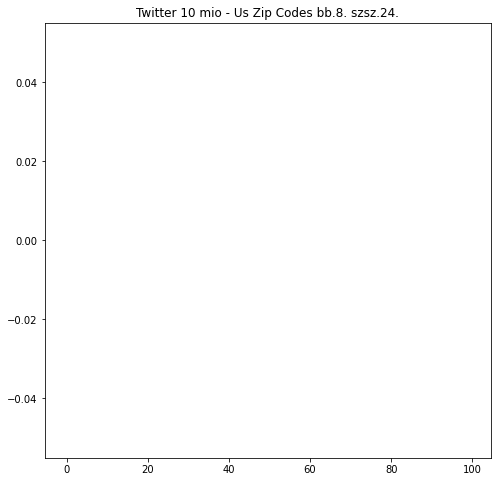

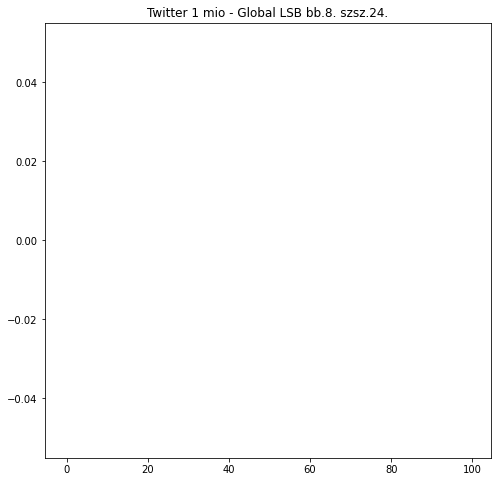

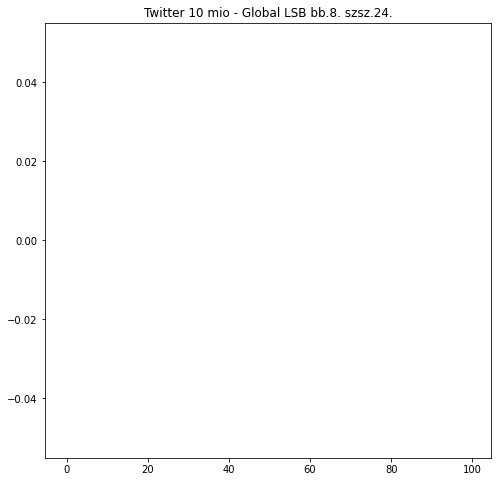

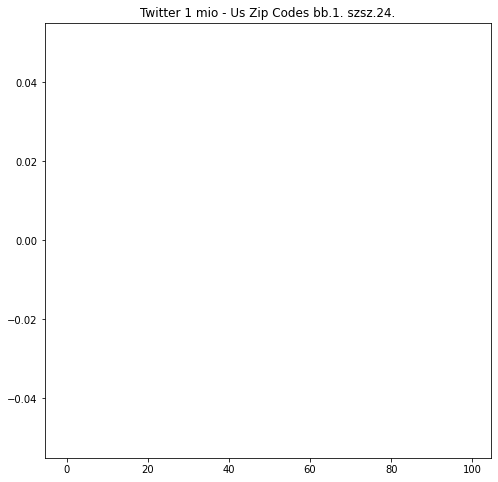

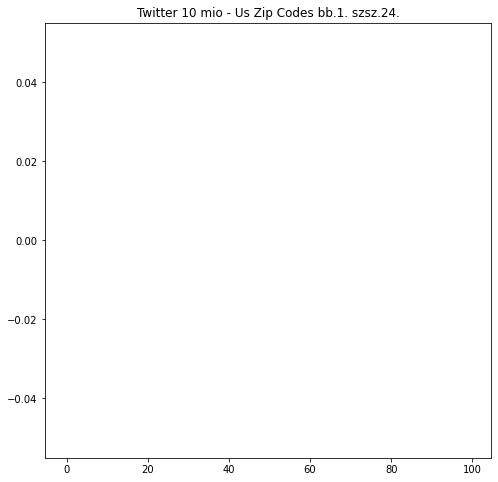

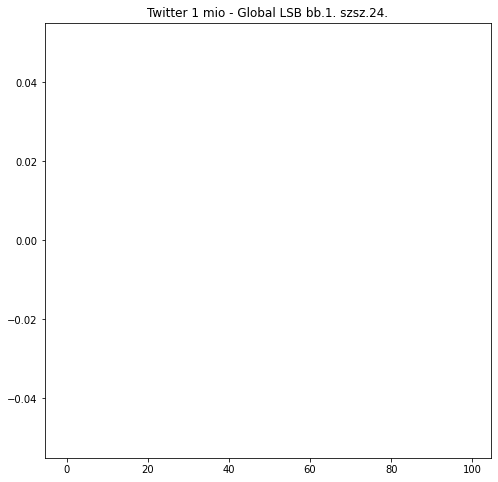

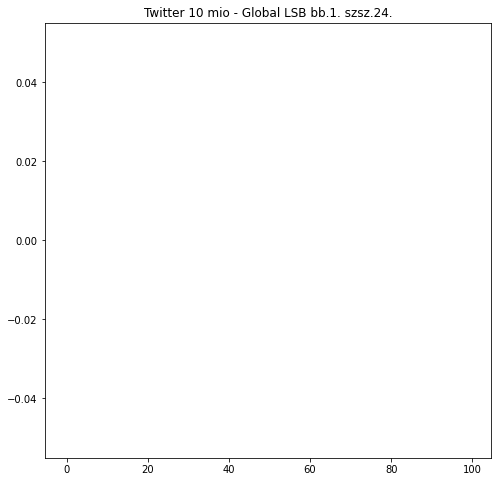

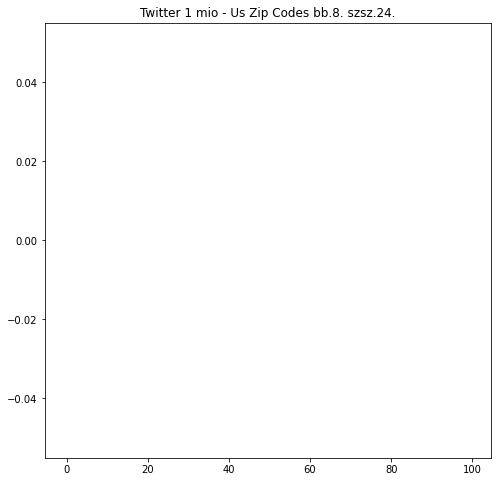

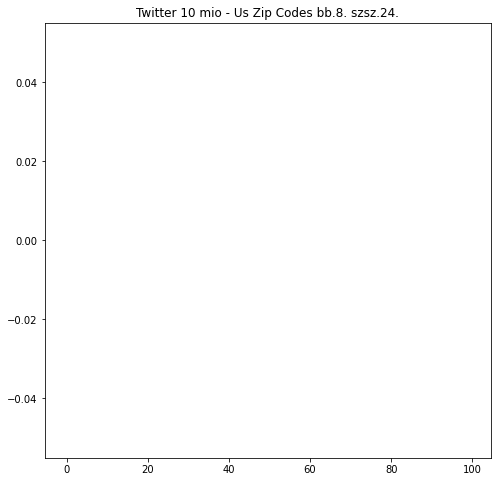

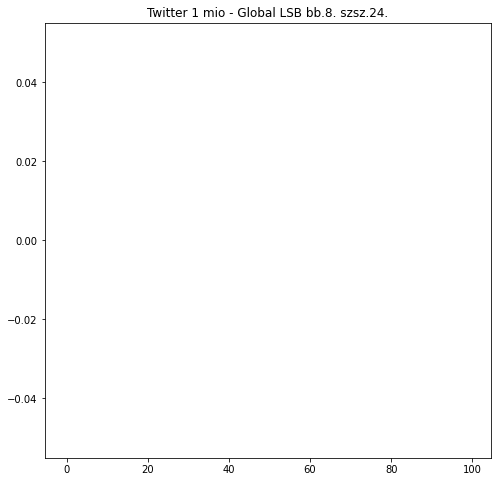

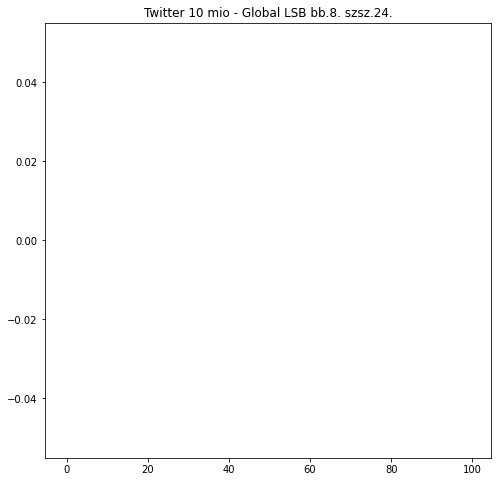

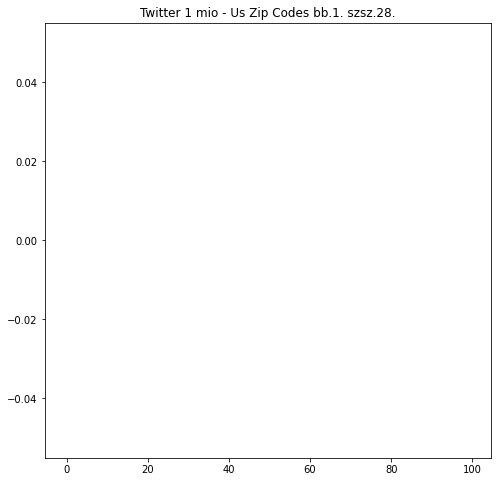

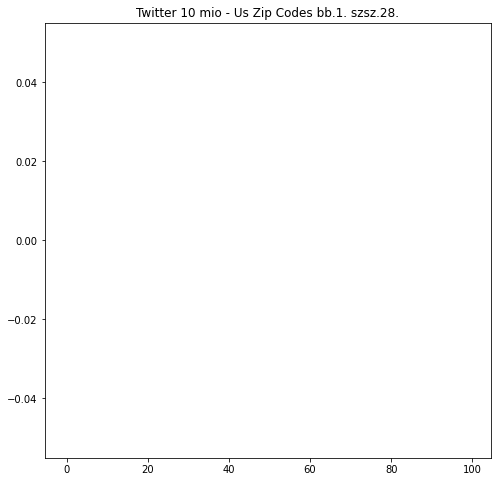

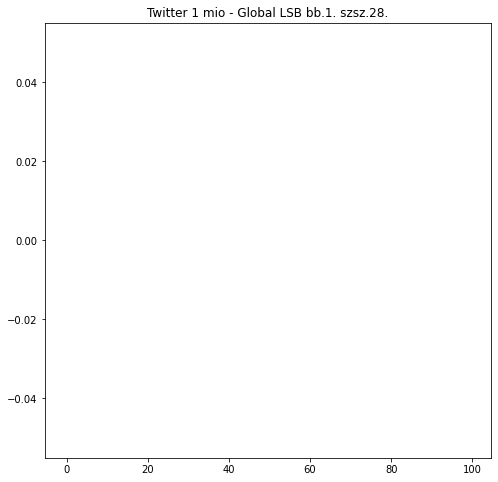

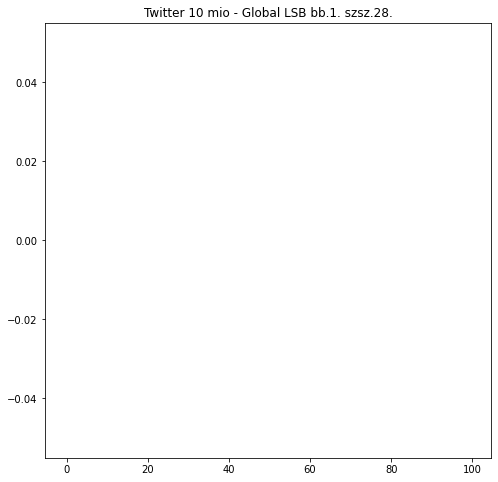

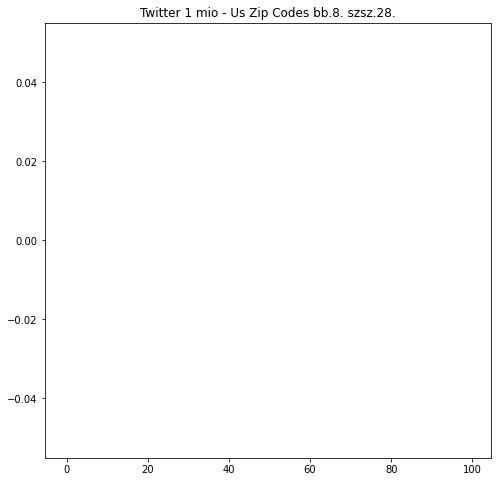

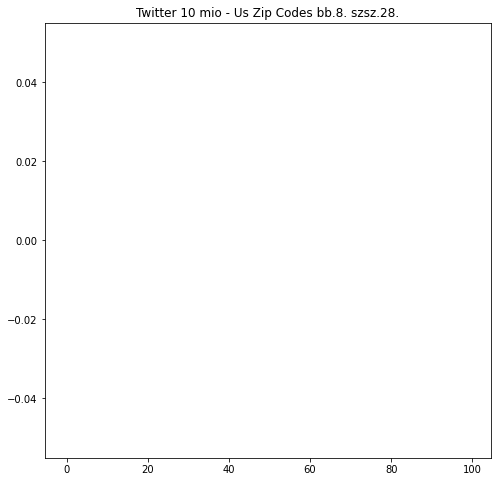

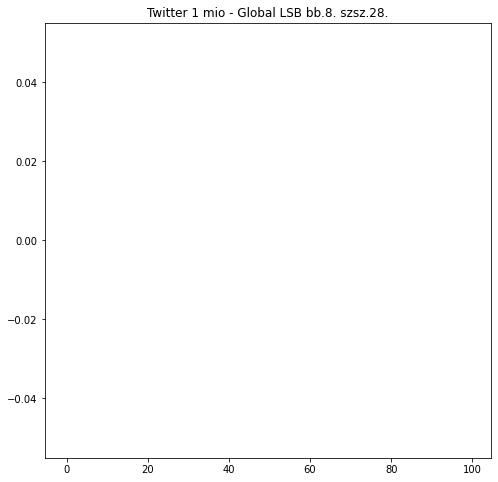

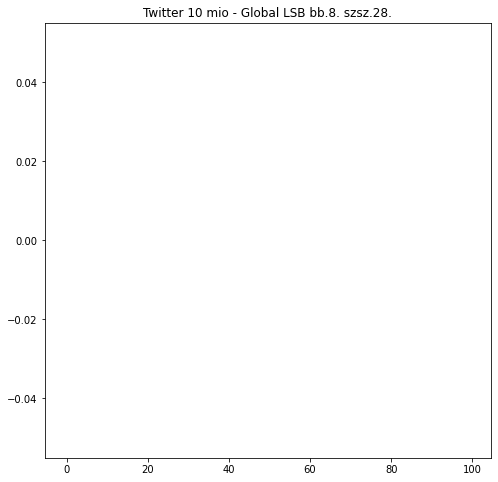

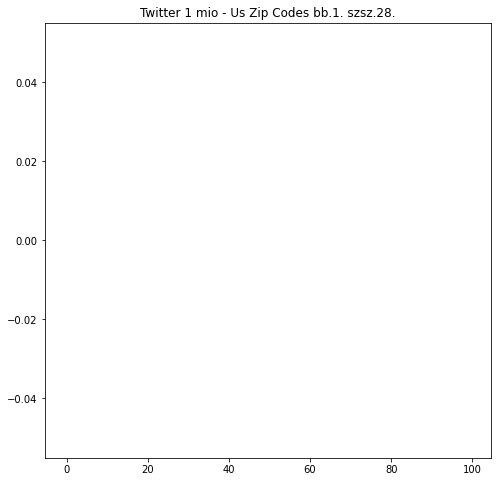

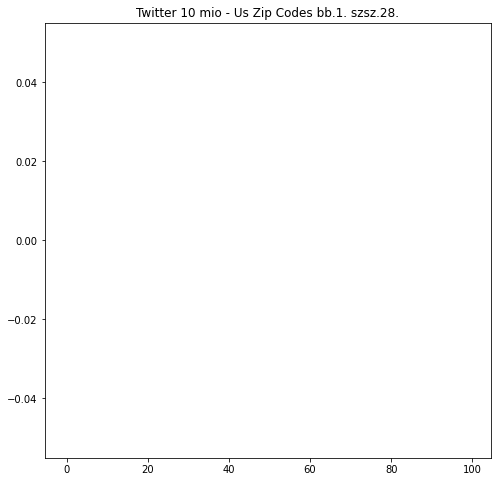

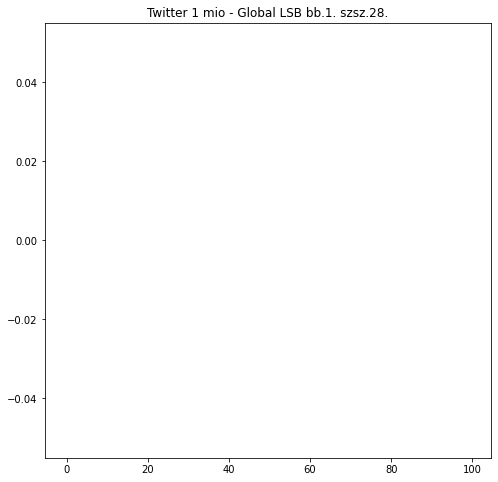

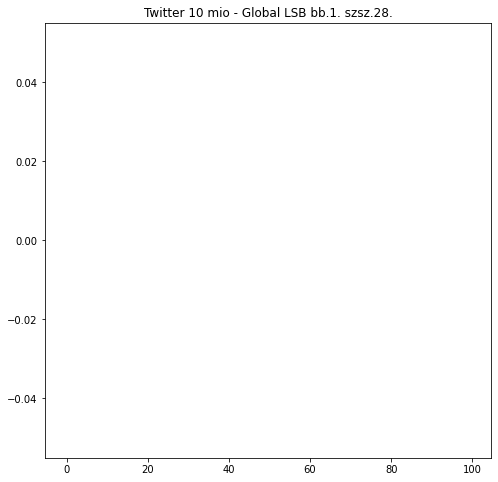

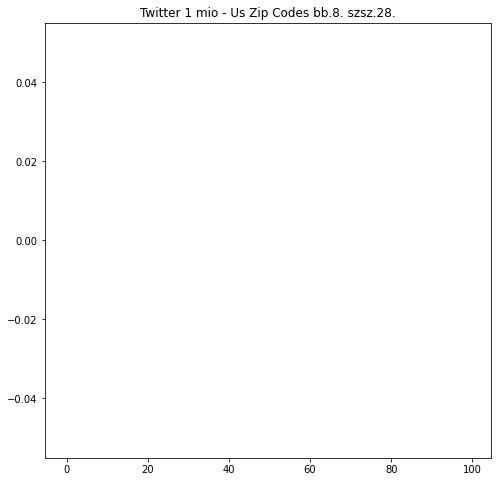

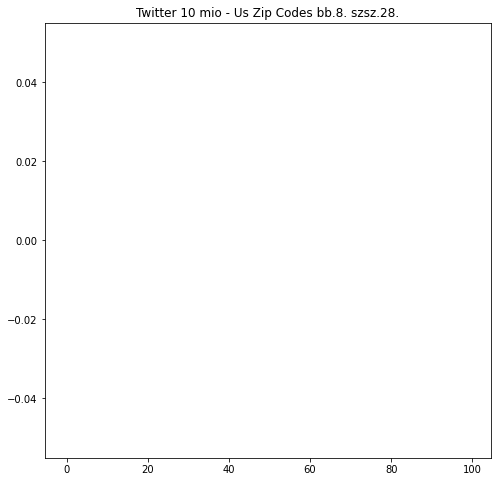

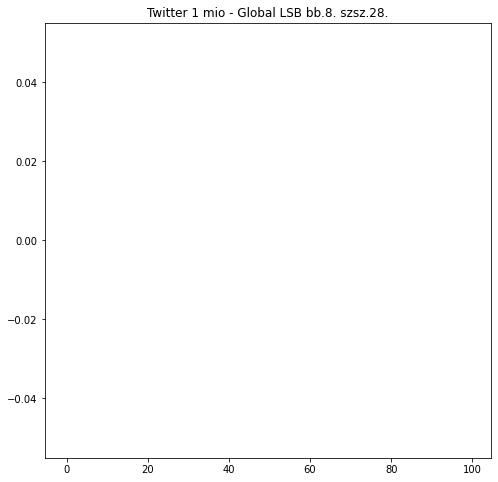

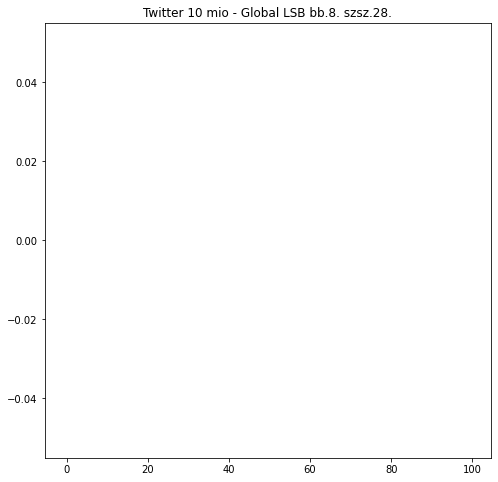

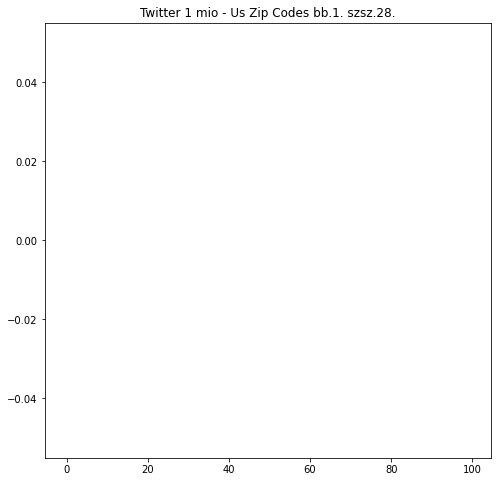

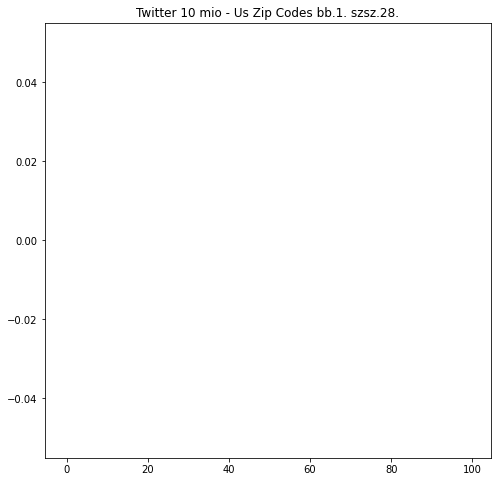

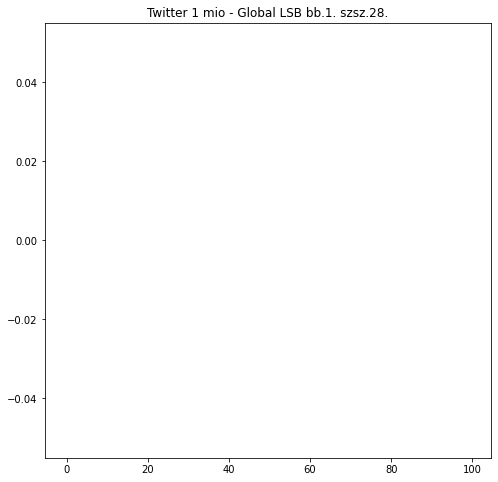

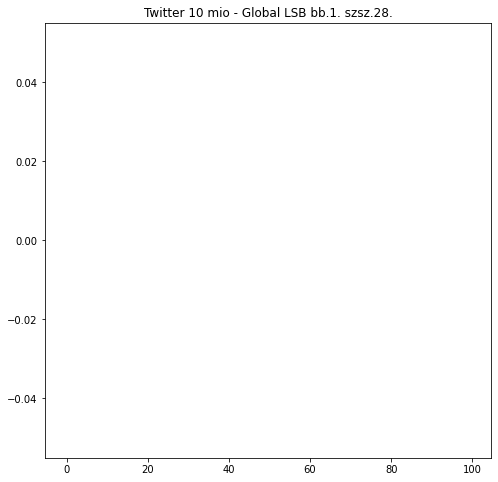

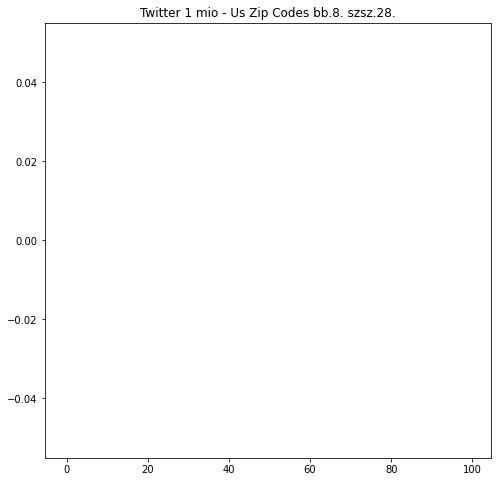

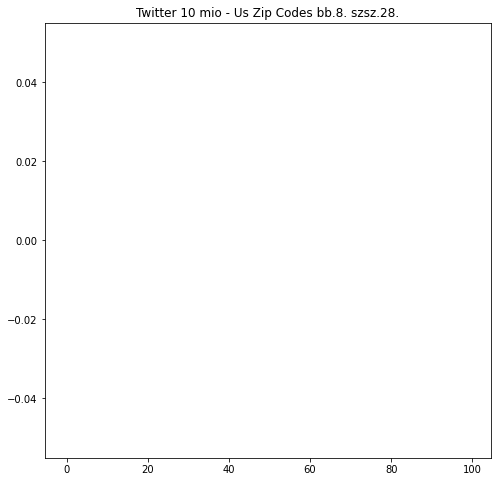

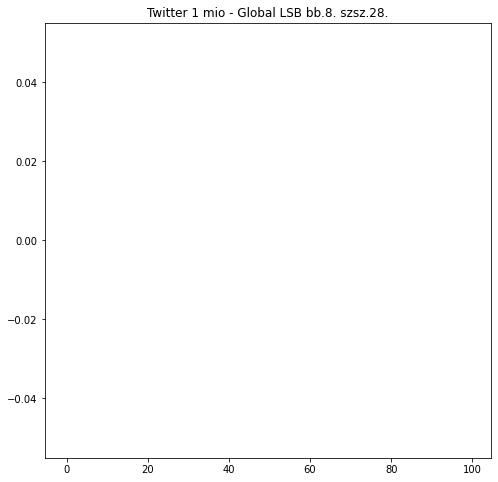

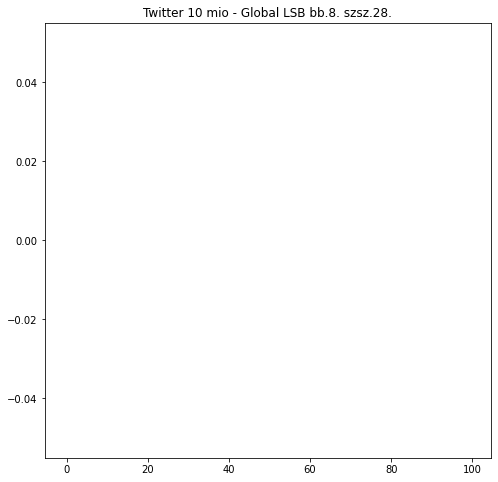

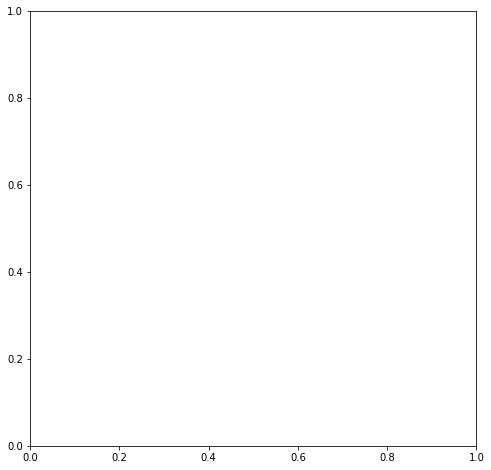

In [7]:
from scipy import signal
from PIL import Image
def make_hist(size, cfgs):
    bits_map, logsize_map, numba = make_maps(size,cfgs)
    matrices= {}
    matrix_indices = ["histogram_pc"]
    for shapen,shapef in polygon_sets:
        matrices[shapef] = {}
        for dn, ds in datasets :
            matrices[shapef][ds] = {}
            for mi in matrix_indices:
                matrices[shapef][ds][mi] = np.zeros((len(bits_map),(len(logsize_map))))-1



    x=0
    for c in cfgs :
        # print(fc_to_string(k,c))
        y = 0;
        for shpn, shapef in polygon_sets:
            for  dn, ds in datasets :
                fn = experiments_path + exp_name + "/" + exp_name + f'.w{width}h{height}.{x:04d}.{y}-' + fc_to_string(k,c) \
                + ds + "." + shapef + ".json"
                # print(fn)
                data = load_exp(fn)
                bits = bits_str(c)
                sz = logsize_str(c)
                if data and bits in bits_map and  sz in logsize_map:
                    for mi in matrix_indices:
                        p =  np.abs(data[mi]) #scipy.signal.resample(data[mi], 100)
                        ##p = np.array(Image.fromarray(data[mi]).resize(100,1))
                        #print(p)
                        plt.figure(figsize=figsize)
                        plt.bar(list(np.arange(0,100,100/len(p))),p)
                        plt.title(f'{dn} - {shpn} b{bits} sz{sz}')
                        #plt.show()

            y+=1
        x+=1

   # for shpn, shapef in polygon_sets:
   #     for  dn, ds in datasets :
   #         for mi in matrix_indices:   
   #             print(matrices[shapef][ds][mi])
make_hist(1,cfgs)
save_figs("polygons_test_hist1.pdf")
make_hist(2,cfgs)
save_figs("polygons_test_hist2.pdf")
make_hist(3,cfgs)
save_figs("polygons_test_hist3.pdf")

In [66]:
from scipy import signal
from PIL import Image
k = 8;
x = 0;
width = 16 * 8192
height = 16 * 8192
exp_name = "test_polygons";

cfgs = load_configs(exp_name)
print(len(cfgs))

datasets =[("Twitter 1 mio","twitter_1mio_coords.h5"), 
           ("Twitter 10 mio","twitter_10mio_coords.h5"),
  
          ]

"""           ("Twitter 100 mio","twitter_100mio_coords.h5"),
           ("Asia 100 mio","asia_100mio_coords.h5"),
           ("Asia 200 mio","asia_200mio_coords.h5"),
           ("Asia 500 mio","asia_500mio_coords.h5"),
           ("Asia 1 bil","asia_1bil_coords.h5"),
          
       """ 
def make_hist_3d(size, cfgs):
    bits_map, logsize_map, numba = make_maps(size,cfgs)
    
    lb = len(bits_map)
    lls = len(logsize_map)
    
    matrices= {}
    matrix_indices = ["histogram_pc"]
    for shapen,shapef in polygon_sets:
        matrices[shapef] = {}
        for dn, ds in datasets :
            matrices[shapef][ds] = {}
            for mi in matrix_indices:
                matrices[shapef][ds][mi] = np.zeros((128,lb*lls))-1
    width = 16 * 8192
    height = 16 * 8192
    xlabels = []
    
    for b in logsize_map.keys():
        for a in bits_map.keys():
            xlabels.append(f'{a} {b}')
    
    
    x=0
    for c in cfgs :
        # print(fc_to_string(k,c))
        y = 0;
        for shpn, shapef in polygon_sets:
            for  dn, ds in datasets :
                fn = experiments_path + exp_name + "/" + exp_name + f'.w{width}h{height}.{x:04d}.{y}-' + fc_to_string(k,c) \
                + ds + "." + shapef + ".json"
                # print(fn)
                data = load_exp(fn)
                bits = bits_str(c)
                sz = logsize_str(c)
                if data and bits in bits_map and  sz in logsize_map:
                    for mi in matrix_indices:
                        p =  np.abs(data[mi])
                        a = bits_map[bits]
                        b = logsize_map[sz]
                        matrices[shapef][ds][mi][:, a+b*lb] = p
                        


            y+=1
        x+=1

    for shpn, shapef in polygon_sets:
        for  dn, ds in datasets :
            for mi in matrix_indices:   
                print(matrices[shapef][ds][mi].shape)
                ms = matrices[shapef][ds][mi].shape
                
                fig = plt.figure(figsize=(12, 12))
                ax1 = fig.add_subplot(111, projection='3d')

                lb = len(bits_map)
                lls = len(logsize_map)
                print(lb)
                print(lls)
                print(lb*lls)
                
                _x = np.arange(0,ms[1])
                _y = np.arange(0,100,100/ms[0])
                X, Y = np.meshgrid(_x, _y)
                x, y = X.ravel(), Y.ravel()
                R = np.sqrt(X**2 + Y**2)
                Z = np.sin(R)

                top = matrices[shapef][ds][mi].ravel()
                bottom = np.zeros_like(top)
                width = depth = 1
       
                print(X.shape)
                print(Y.shape)
                print(x.shape)
                print(y.shape)
                
                
                print(R.shape)
                print(Z.shape)
                print(top.shape)
                
                

                surf = ax1.bar3d(x,y, bottom, width, depth,  top, shade=True,)
                ax1.set_title(f'{dn}-{shpn}')

                ax1.set_xticklabels(list(xlabels))
                ax1.set_xlabel('Configuration')
                ax1.set_ylabel('Percentile')
                ax1.set_zlabel('% Error')
                

                #fig.colorbar(surf, shrink=0.25, aspect=9)
                #plt.show()
                
make_hist_3d(1,cfgs)
save_figs("polygons_test_hist1_3d.pdf")                
make_hist_3d(2,cfgs)
save_figs("polygons_test_hist2_3d.pdf")

432
(128, 8)
2
4
8
(128, 8)
(128, 8)
(1024,)
(1024,)
(128, 8)
(128, 8)
(1024,)
(128, 8)
2
4
8
(128, 8)
(128, 8)
(1024,)
(1024,)
(128, 8)
(128, 8)
(1024,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:112: UserWarning: FixedFormatter should only be used together with FixedLocator


(128, 8)
2
4
8
(128, 8)
(128, 8)
(1024,)
(1024,)
(128, 8)
(128, 8)
(1024,)
(128, 8)
2
4
8
(128, 8)
(128, 8)
(1024,)
(1024,)
(128, 8)
(128, 8)
(1024,)
-->  Saving all figures... polygons_test_hist1_3d.pdf


100%|██████████| 4/4 [00:02<00:00,  1.70it/s]


(128, 84)
7
12
84
(128, 84)
(128, 84)
(10752,)
(10752,)
(128, 84)
(128, 84)
(10752,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:112: UserWarning: FixedFormatter should only be used together with FixedLocator


(128, 84)
7
12
84
(128, 84)
(128, 84)
(10752,)
(10752,)
(128, 84)
(128, 84)
(10752,)
(128, 84)
7
12
84
(128, 84)
(128, 84)
(10752,)
(10752,)
(128, 84)
(128, 84)
(10752,)
(128, 84)
7
12
84
(128, 84)
(128, 84)
(10752,)
(10752,)
(128, 84)
(128, 84)
(10752,)
-->  Saving all figures... polygons_test_hist2_3d.pdf


100%|██████████| 4/4 [00:22<00:00,  5.57s/it]
